# DICE SM Analysis 

## Setup & Initialisation of levers and uncertainties 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import itertools

import os 
os.chdir(os.getcwd())
import sys
# insert at 1, 0 is the script path (or '' in REPL)
pydice_folder = os.path.dirname(os.getcwd())+"\\1_Model"
sys.path.insert(1, pydice_folder)


from changefont import change_fontsize

from specify import specify_levers
from scipy.stats import norm, lognorm, cauchy

from ema_workbench import (save_results, load_results)

from ema_workbench.em_framework.evaluators import perform_experiments, LHS, SOBOL, MORRIS
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring
# from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION

from ema_workbench.util import ema_logging
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)

from PyDICE_V4 import PyDICE

C:\Users\Shajee\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)

In [3]:
model = PyDICE()
dice_sm = Model('dicesmEMA', function = model)

## Exploration

In [4]:
dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                         IntegerParameter('t2xco2_dist',0,2),
                         IntegerParameter('fdamage',0,2),
                         RealParameter('tfp_gr',  0.07, 0.09),
                         RealParameter('sigma_gr', -0.012, -0.008),
                         RealParameter('pop_gr', 0.1, 0.15),
                         RealParameter('fosslim',  4000.0, 13649),
                         IntegerParameter('cback', 100, 600)]

dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                  RealParameter('irstp',  0.001, 0.015),
                  IntegerParameter('periodfullpart', 10, 58),
                  IntegerParameter('miu_period', 10, 58)]

dice_sm.outcomes = [ScalarOutcome('Atmospheric Temperature 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Damages 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Utility 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Atmospheric Temperature 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2050', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2050', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2100', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2100', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2150', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2150', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2200', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2200', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2300', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2300', ScalarOutcome.MAXIMIZE)]

In [5]:
n_scenarios=540000
nord_optimal_policy = Policy('nord_optimal_policy', **specify_levers(np.mean(dice_opt.iloc[129]),0.015,0,29))

In [6]:
# start = time.time()
# with MultiprocessingEvaluator(dice_sm) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios, policies=nord_optimal_policy)
# end = time.time()
#
# print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

In [7]:
file_name = 'exploration_V4_' + str(n_scenarios) + 'scen_' + 'nordhaus_optimal_policy_' + str(4) + 'obj' + '.tar.gz'
# save_results(results, file_name)
results = load_results(file_name)

[MainProcess/INFO] results loaded succesfully from C:\Users\Shajee\Documents\GitHub\PyDICE\3_Nordhaus_Optimal_Policy_Exploration\exploration_V4_540000scen_nordhaus_optimal_policy_4obj.tar.gz


In [8]:
experiments, outcomes = results

In [9]:
clr_palette = ([sns.cubehelix_palette(8)[6],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[10]])

### Pairplots

#### Effect of distributions on the output

In [10]:
out_DF = pd.DataFrame(outcomes)
t2xco2_dist = experiments['t2xco2_dist']
out_DF['t2xco2_dist'] = t2xco2_dist
out_DF['t2xco2_dist'] = out_DF['t2xco2_dist'].apply(lambda x: 'norm' if x==0 else ('lognorm' if x==1 else 'cauchy'))

In [11]:
out_DF = out_DF.sort_values([out_DF.columns[-1]], ascending=1)

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


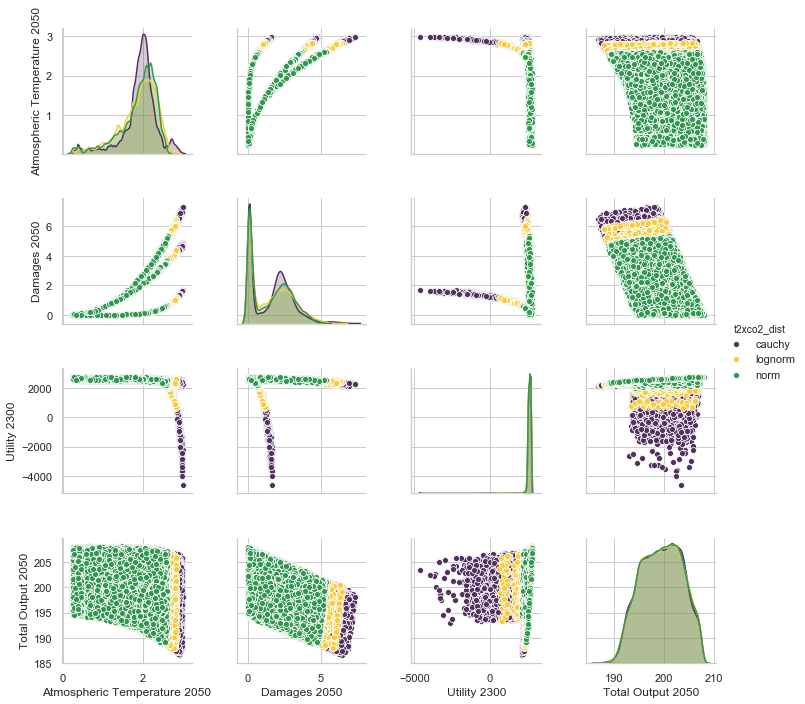

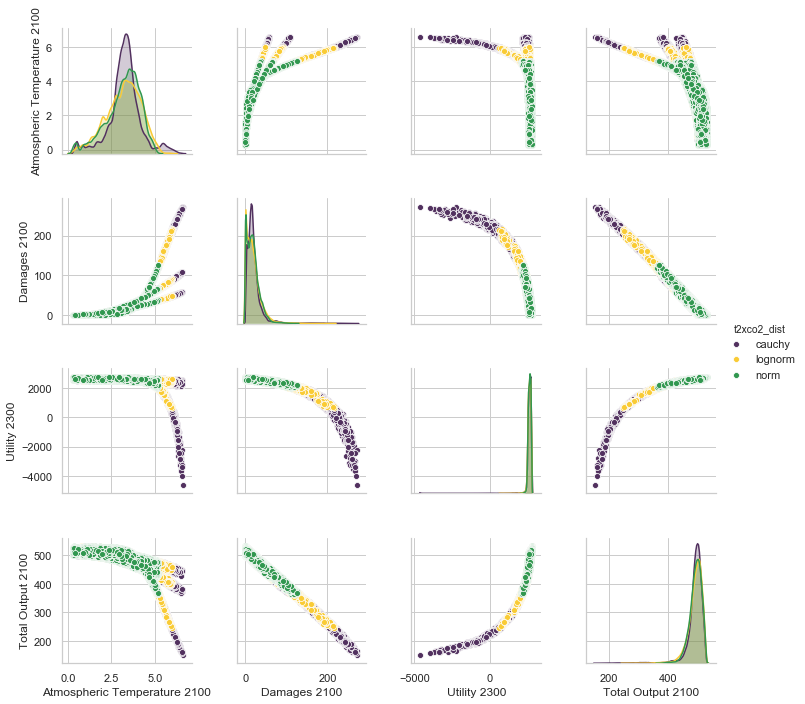

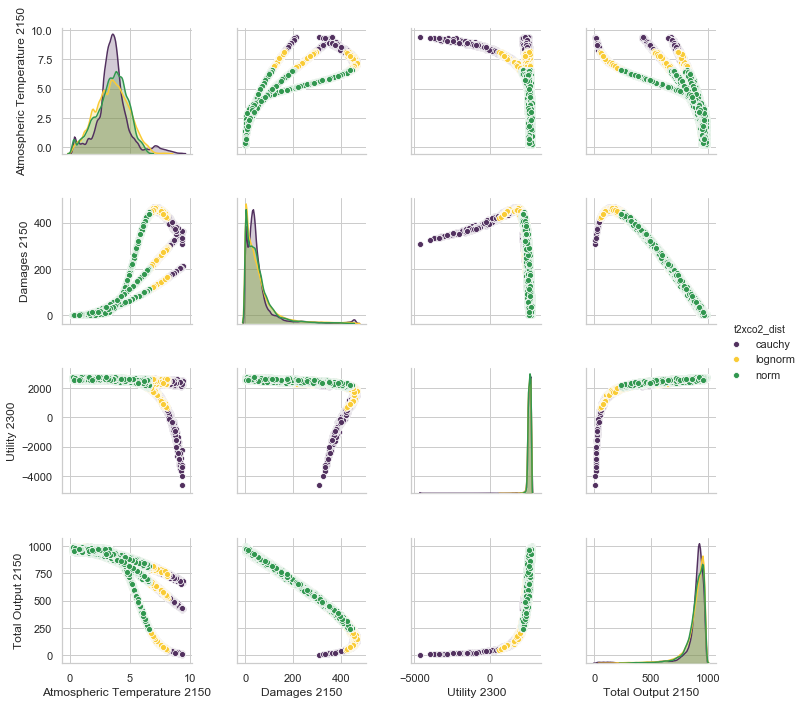

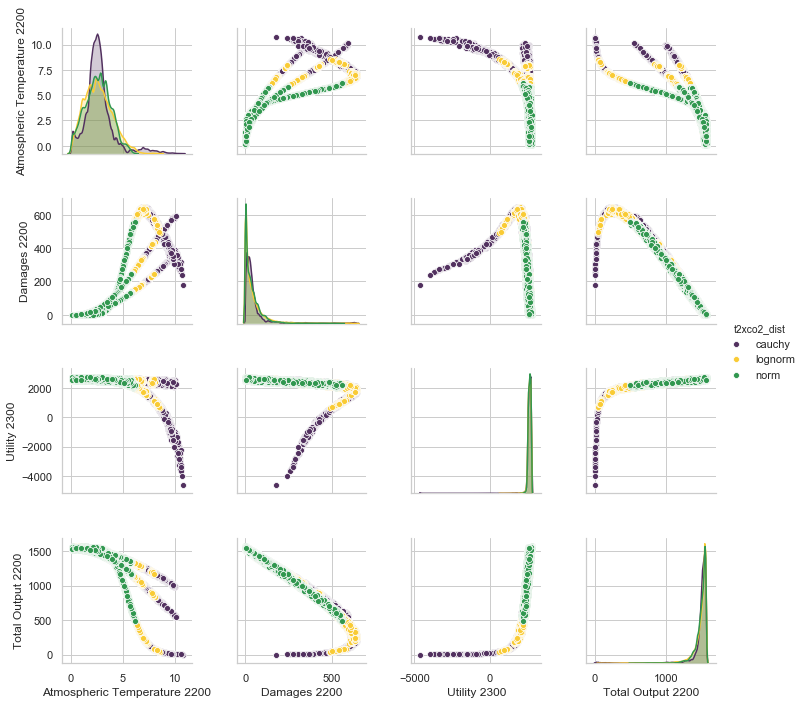

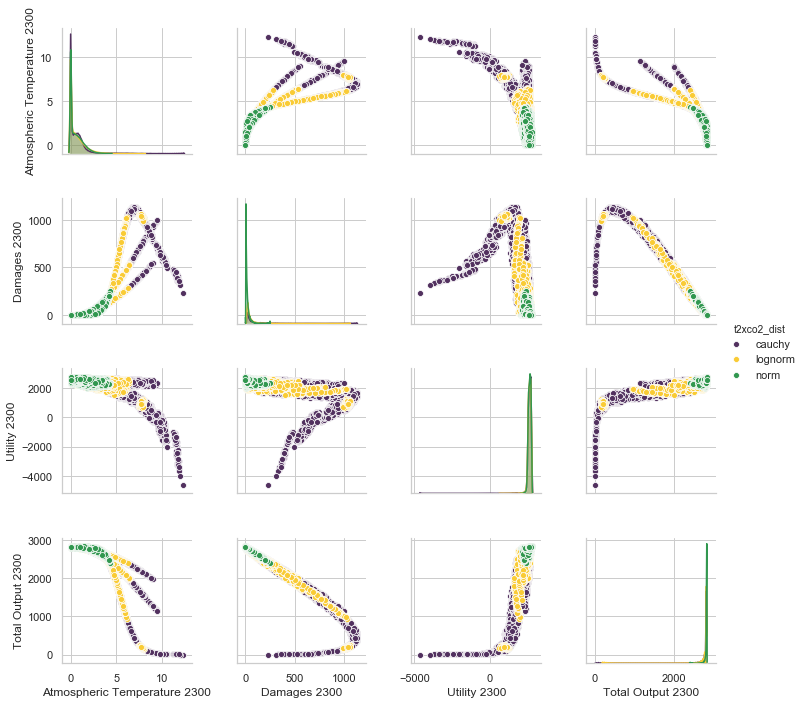

In [13]:
sns.set(style = "whitegrid")
for _ in range(1,6):
    colmlst = list(range(0+_*4,4+_*4))
    namelist = colmlst[:]
    colmlst[2] = -3
    namelist[2] = -2
    ppDF = out_DF.iloc[:,colmlst+[-1]]
    sns_plot = sns.pairplot(ppDF, hue='t2xco2_dist', palette=clr_palette, vars=list(list(outcomes.keys())[i] for i in namelist))
    plt.show()
    sns_plot.savefig('pairplot_'+str(list(outcomes.keys())[_*4][-4:])+'_dist_nordhaus_opt_policy_util2300'+'_V4.png')

#### Effect of damage function on the output

In [16]:
out_DF = pd.DataFrame(outcomes)
fdamage = experiments['fdamage']
out_DF['fdamage'] = fdamage # include damage column into the model output model
out_DF['fdamage'] = out_DF['fdamage'].apply(lambda x: 'Nordhaus - 2013' if x==0 else ('Newbold & Daigneault(Exp) - 2009' if x==1 else 'Weitzman - 2010'))

In [17]:
out_DF.head()

Atmospheric Temperature 2010  Damages 2010  Utility 2010  \
0                           0.8      0.091945  -3689.589004   
1                           0.8      0.000584  -3689.253400   
2                           0.8      0.108649  -3689.651329   
3                           0.8      0.108649  -3689.650602   
4                           0.8      0.108649  -3689.651235   

   Total Output 2010  Atmospheric Temperature 2050  Damages 2050  \
0          63.489964                      1.317451      0.970565   
1          63.581088                      1.773455      0.050487   
2          63.473062                      1.615968      1.439738   
3          63.473259                      1.697310      1.545742   
4          63.473088                      2.309064      2.812857   

   Utility 2050  Total Output 2050  Atmospheric Temperature 2100  \
0  -1896.729124         196.941370                      1.942768   
1  -1873.111525         200.539805                      2.787191   
2  -1839.168690         204.505534                      2.507020   
3  -1878.323171         199.275472                      2.585263   
4  -1903.466266         194.349526                      4.104393   

   Damages 2100  ...  Total Output 2150  Atmospheric Temperature 2200  \
0      6.491804  ...         963.456947                      0.954218   
1      2.663945  ...         958.178995                      1.973754   
2      8.822566  ...         947.935391                      1.509748   
3      9.249840  ...         961.639735                      1.859128   
4     22.811428  ...         886.820931                      4.068045   

   Damages 2200  Utility 2200  Total Output 2200  \
0      3.473548   2086.332132        1551.477286   
1      0.793016   2148.099798        1544.270875   
2      9.477504   2231.199383        1530.653367   
3     14.392962   2138.851793        1542.273883   
4     67.428208   2034.436868        1449.105352   

   Atmospheric Temperature 2300  Damages 2300  Utility 2300  \
0                      0.000000      0.000000   2587.742412   
1                      0.350272      0.022879   2649.695619   
2                      0.000000      0.000000   2732.976051   
3                      0.765281      4.437848   2640.441673   
4                      2.079273     32.548044   2533.288832   

   Total Output 2300                           fdamage  
0        2836.085647  Newbold & Daigneault(Exp) - 2009  
1        2830.254275                   Weitzman - 2010  
2        2827.535096                   Nordhaus - 2013  
3        2832.320241                   Nordhaus - 2013  
4        2782.823723                   Nordhaus - 2013  

[5 rows x 25 columns]

In [18]:
out_DF = out_DF.sort_values([out_DF.columns[-1]], ascending=False)

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


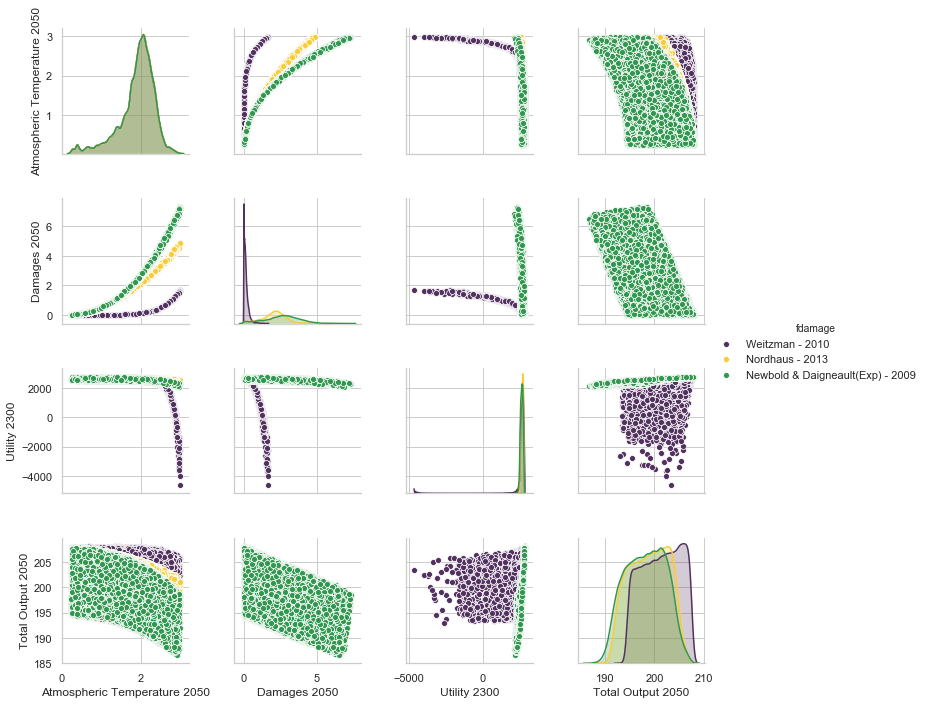

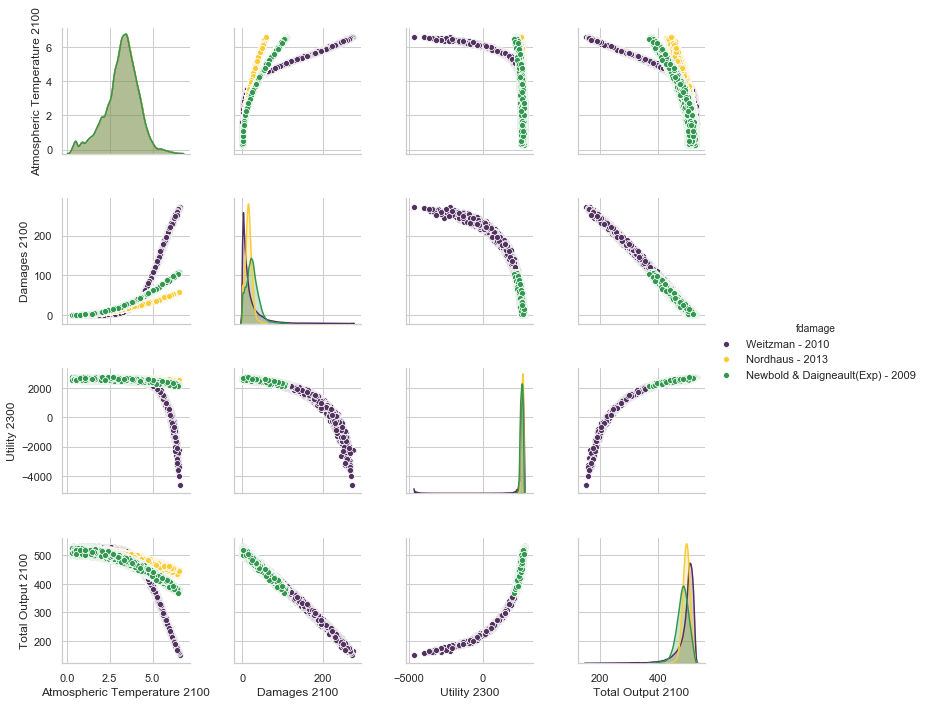

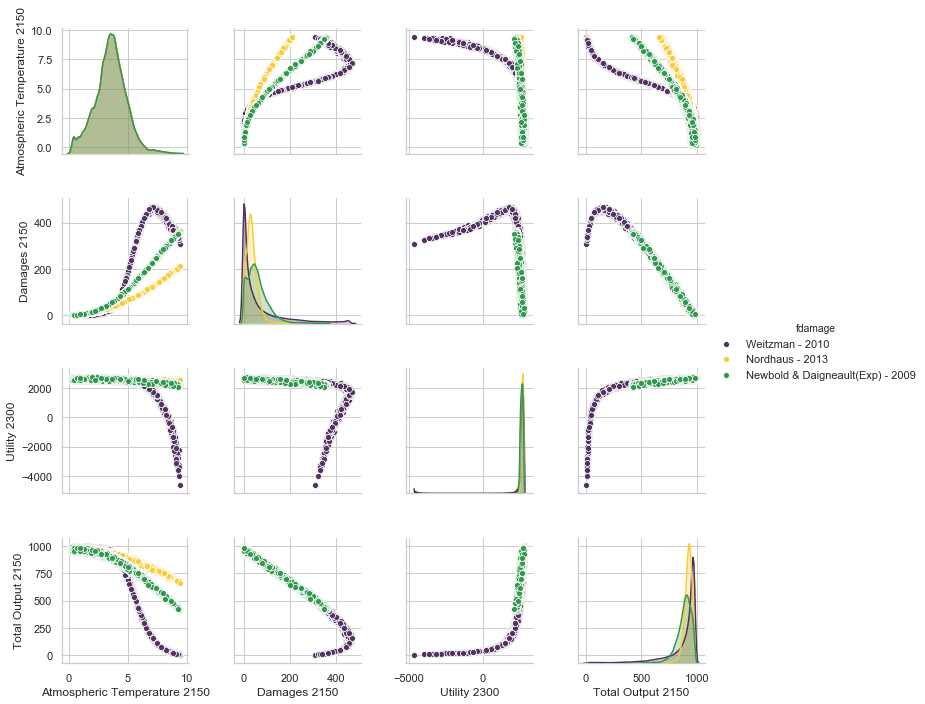

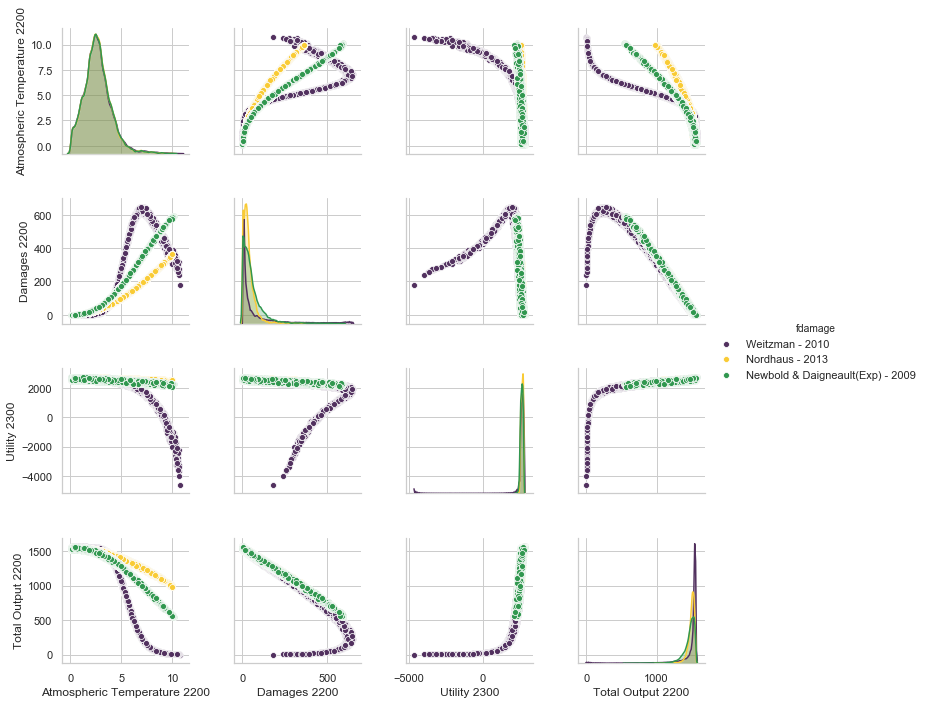

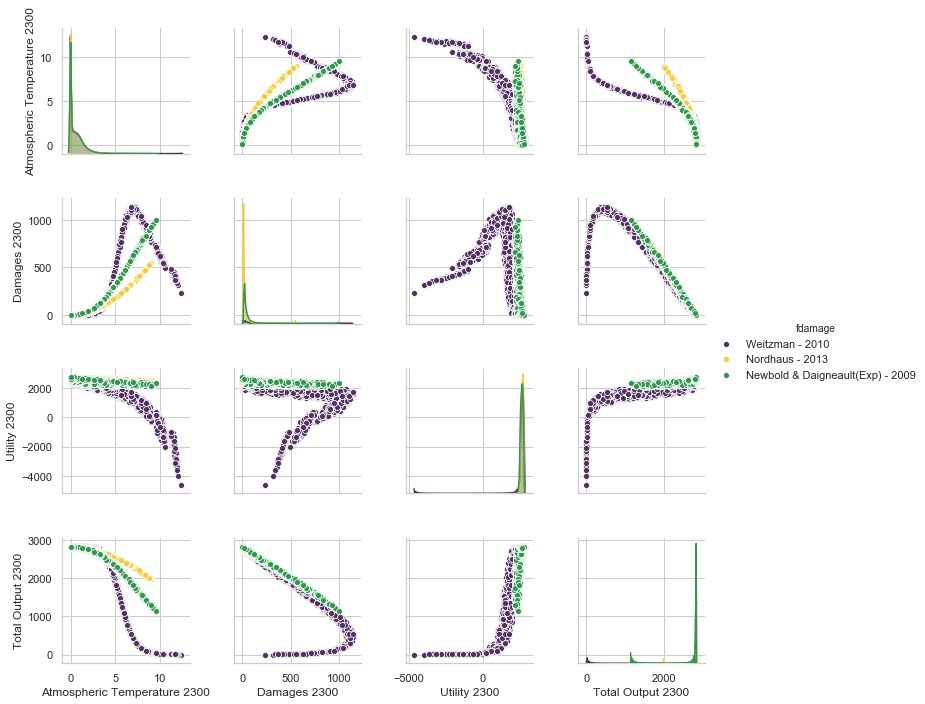

In [20]:
sns.set(style = "whitegrid")
for _ in range(1,6):
    colmlst = list(range(0+_*4,4+_*4))
    namelist = colmlst[:]
    colmlst[2] = -3
    namelist[2] = -2
    ppDF = out_DF.iloc[:,colmlst+[-1]]
    sns_plot = sns.pairplot(ppDF, hue='fdamage', palette=clr_palette, vars=list(list(outcomes.keys())[i] for i in namelist))
    plt.show()
    sns_plot.savefig('pairplot_'+str(list(outcomes.keys())[_*4][-4:])+'_fdamage_nordhaus_opt_policy_util2300'+'_V4.png')

#### Effect of damage function in combination with ecs distributions

In [21]:
out_DF = pd.DataFrame(outcomes)
out_DF['fdamage'] = fdamage
out_DF['t2xco2_dist'] = t2xco2_dist
out_DF['t2xco2_dist'] = out_DF['t2xco2_dist'].apply(lambda x: 'norm' if x==0 else ('lognorm' if x==1 else 'cauchy'))
out_DF['fdamage'] = out_DF['fdamage'].apply(lambda x: ' + nordhaus' if x==0 else (' + newbold' if x==1 else ' + weitzman'))
out_DF['t2xco2_dist+fdamage'] = out_DF['t2xco2_dist'] + out_DF['fdamage']
out_DF = out_DF.drop(out_DF.columns[[-2, -3]], axis=1)

In [22]:
out_DF = out_DF.sort_values([out_DF.columns[-1]], ascending=1)

In [23]:
sns.set(style = "whitegrid", palette=sns.set_palette("tab10"))

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


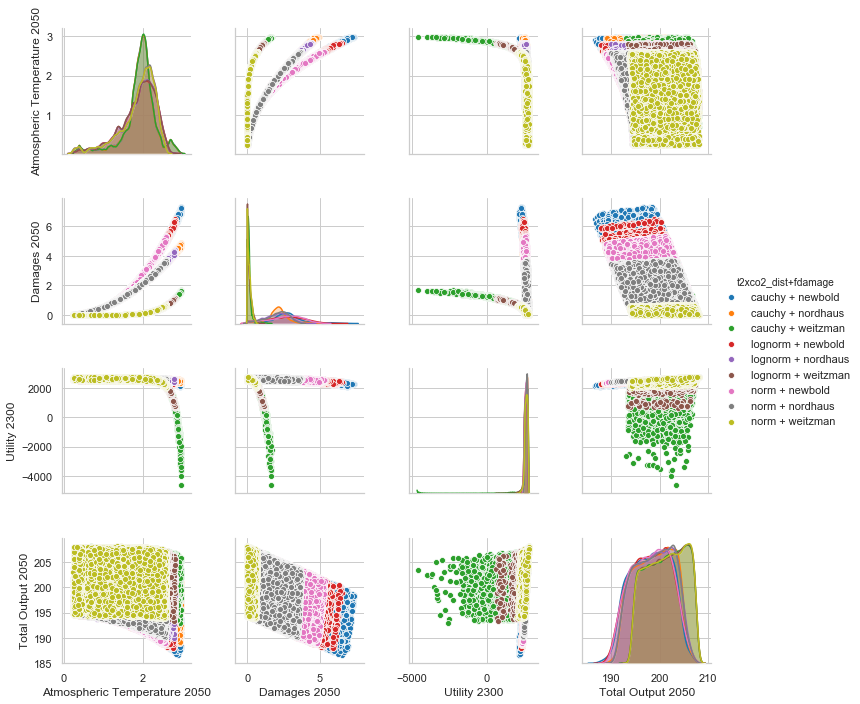

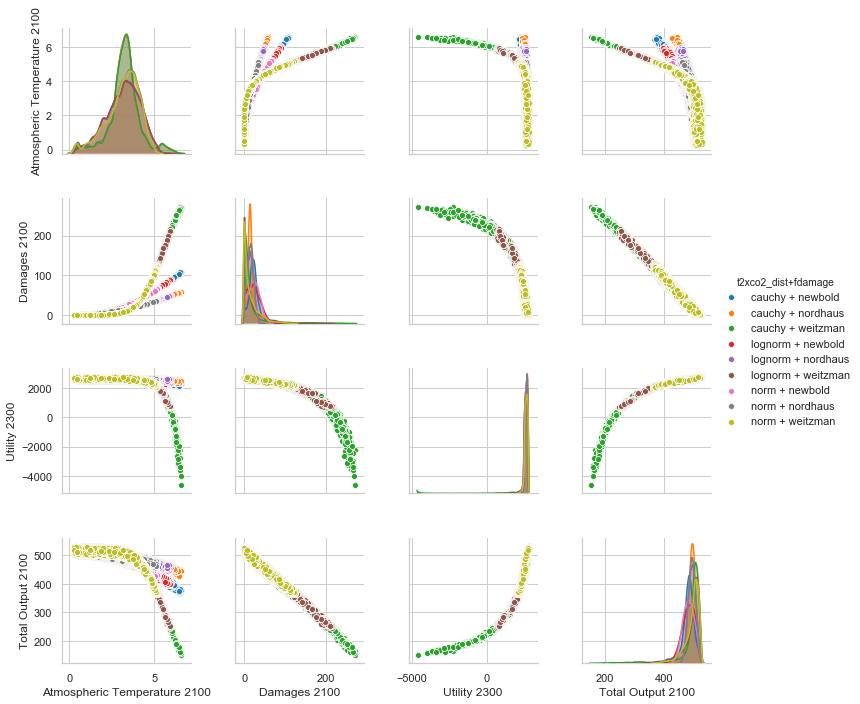

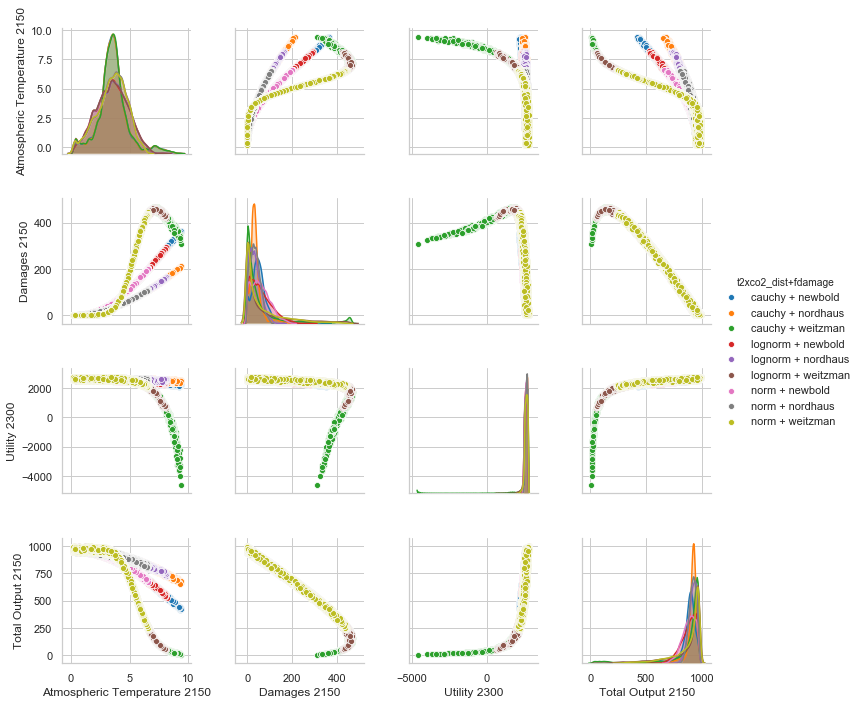

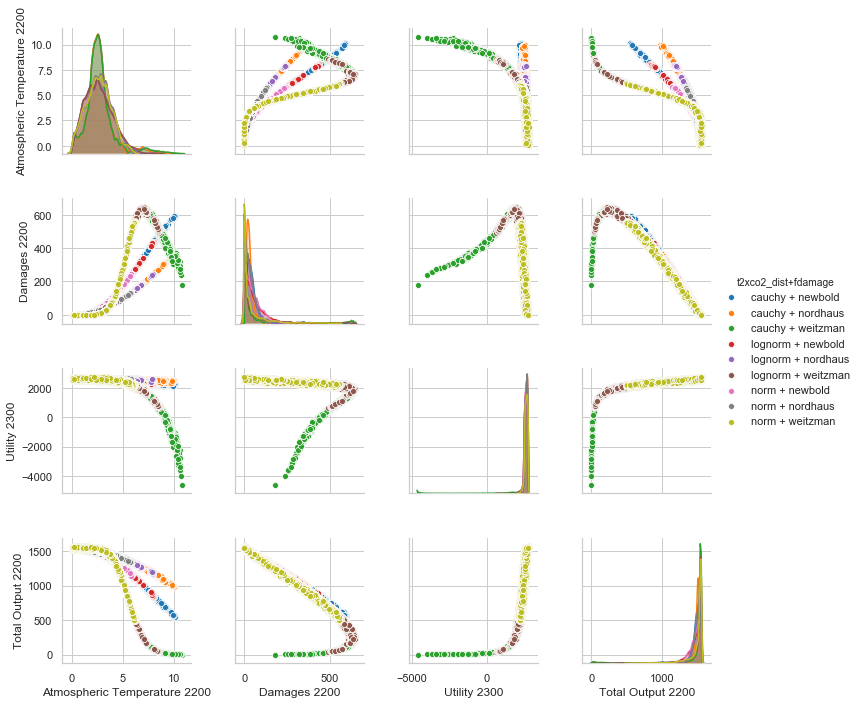

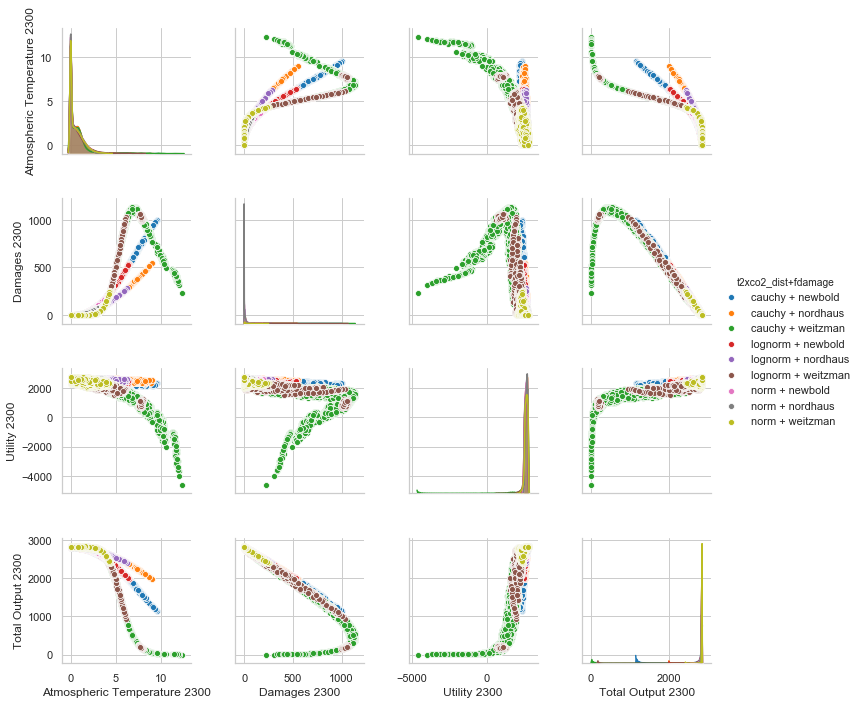

In [24]:
for _ in range(1,6):
    colmlst = list(range(0+_*4,4+_*4))
    namelist = colmlst[:]
    colmlst[2] = -3
    namelist[2] = -2
    ppDF = out_DF.iloc[:,colmlst+[-1]]
    sns_plot = sns.pairplot(ppDF, hue='t2xco2_dist+fdamage', vars=list(list(outcomes.keys())[i] for i in namelist))
    plt.show()
    sns_plot.savefig('pairplot_'+str(list(outcomes.keys())[_*4][-4:])+'_fdamage+dist_nordhaus_opt_policy_util2300'+'_V4.png')

## Statistical Analysis

In [25]:
from scipy.stats import norm, lognorm, cauchy

In [26]:
outDF = pd.DataFrame(outcomes)
expDF = experiments

resDF = pd.concat([expDF,outDF], axis=1, join_axes=[expDF.index])

resDF['t2xco2_dist'] = resDF['t2xco2_dist'].apply(lambda x: 'norm' if x==0 else ('lognorm' if x==1 else 'cauchy'))
resDF['fdamage'] = resDF['fdamage'].apply(lambda x: 'nordhaus' if x==0 else ('newbold' if x==1 else 'weitzman'))

#resDF = resDF.drop(resDF[["fdamage", 't2xco2_dist']], axis=1)

### Distributions

#### DISTPLOT

In [27]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF["t2xco2_dist"]))):
#             sns.distplot(resDF[resDF["t2xco2_dist"] == np.unique(resDF["t2xco2_dist"])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF["t2xco2_dist"])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

In [28]:
# fig.savefig('distplot_'+'dist'+'_nordhaus_opt_policy'+'_V3.png')

#### BOXPLOT

In [29]:
clr_palette = ([sns.cubehelix_palette(10)[5],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[9]])

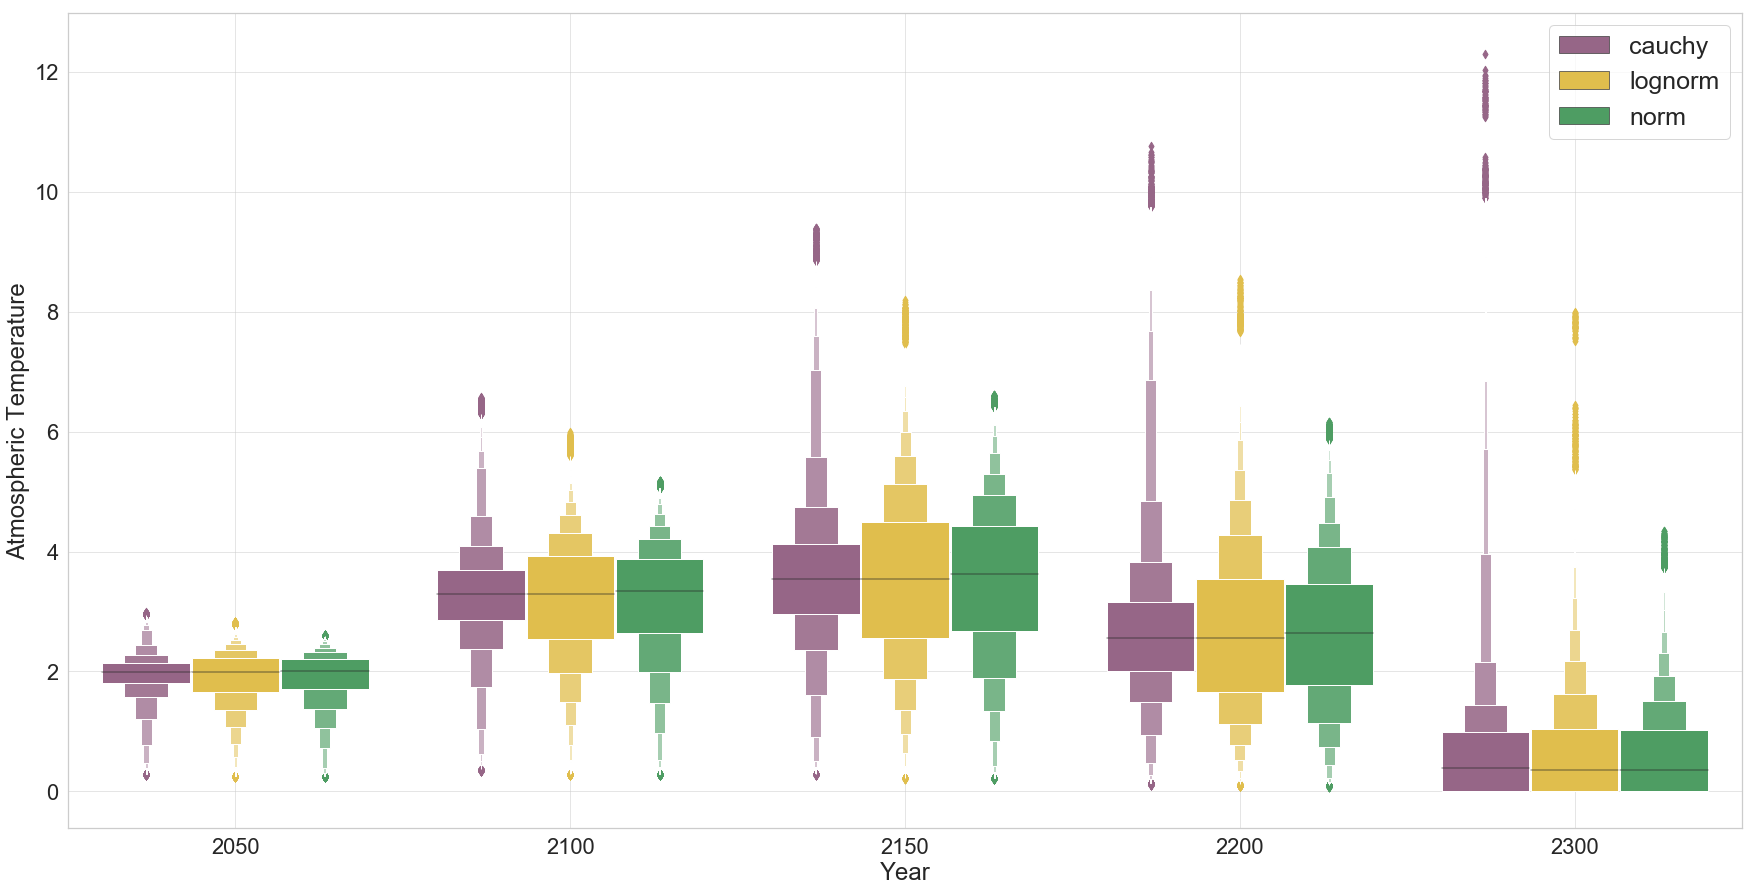

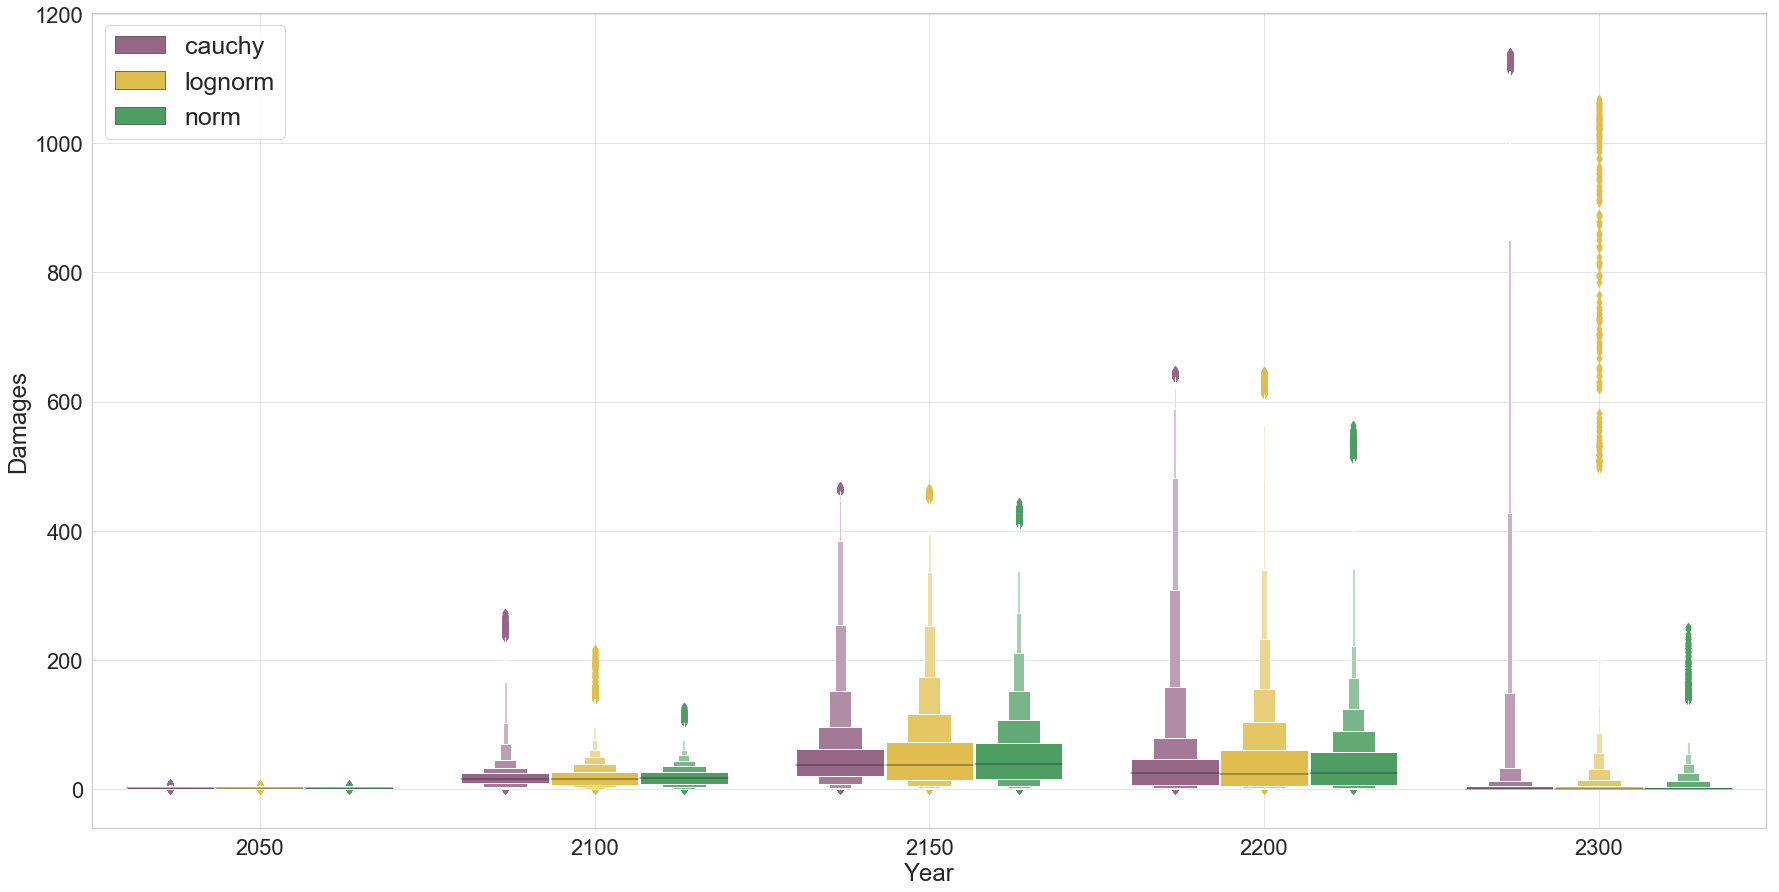

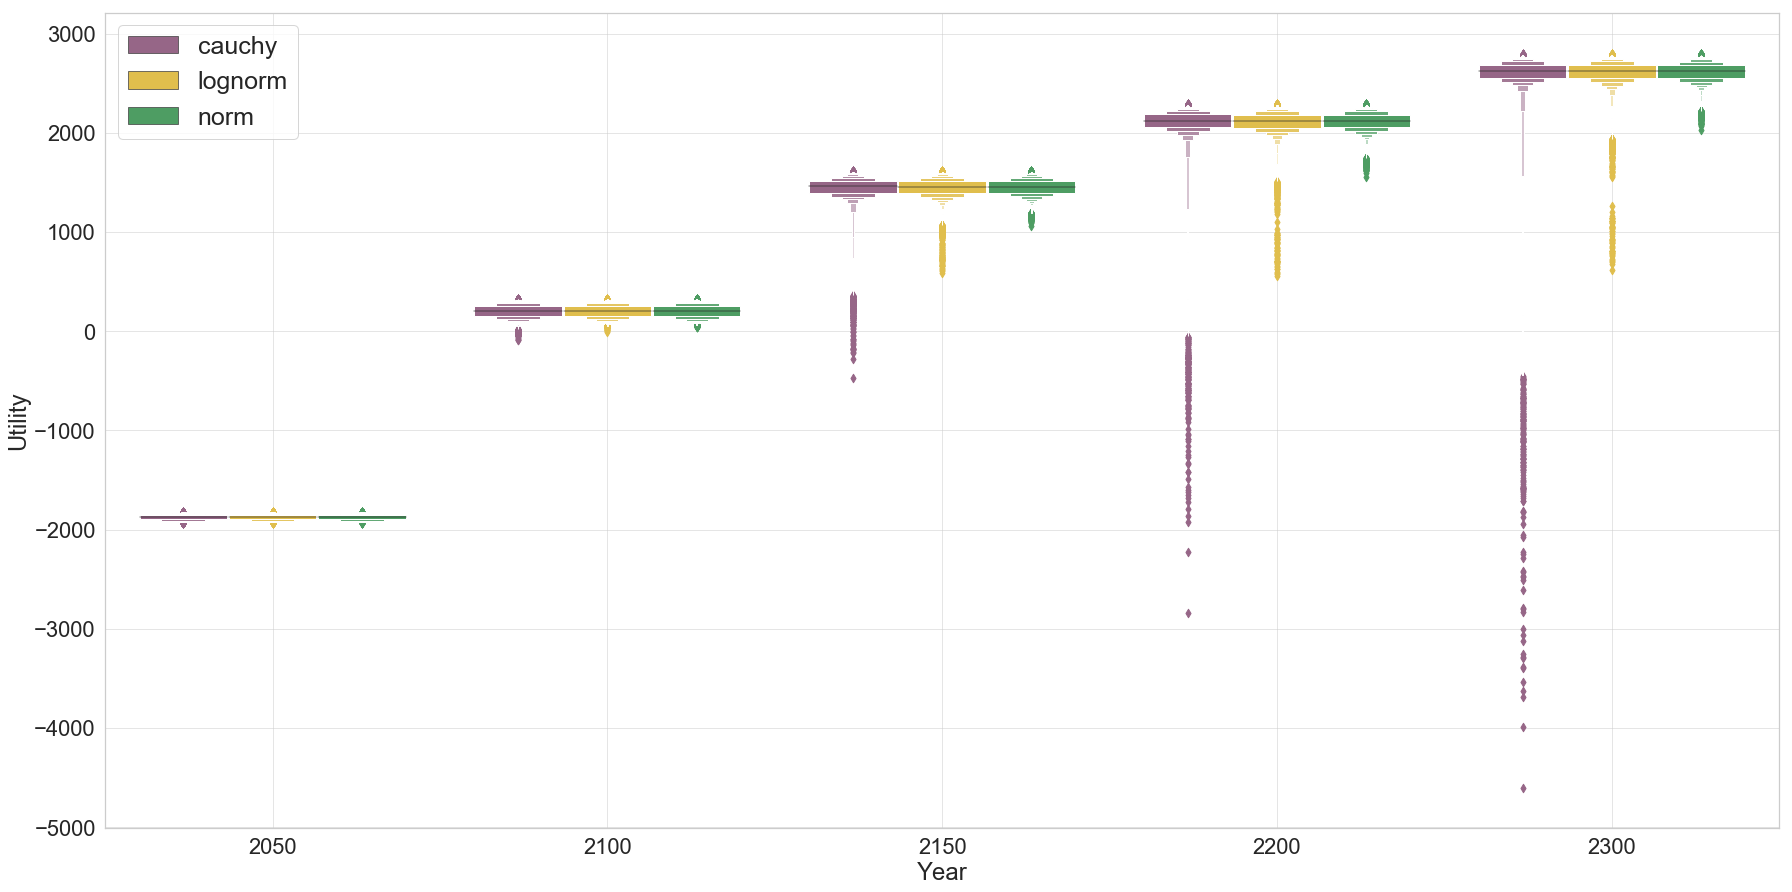

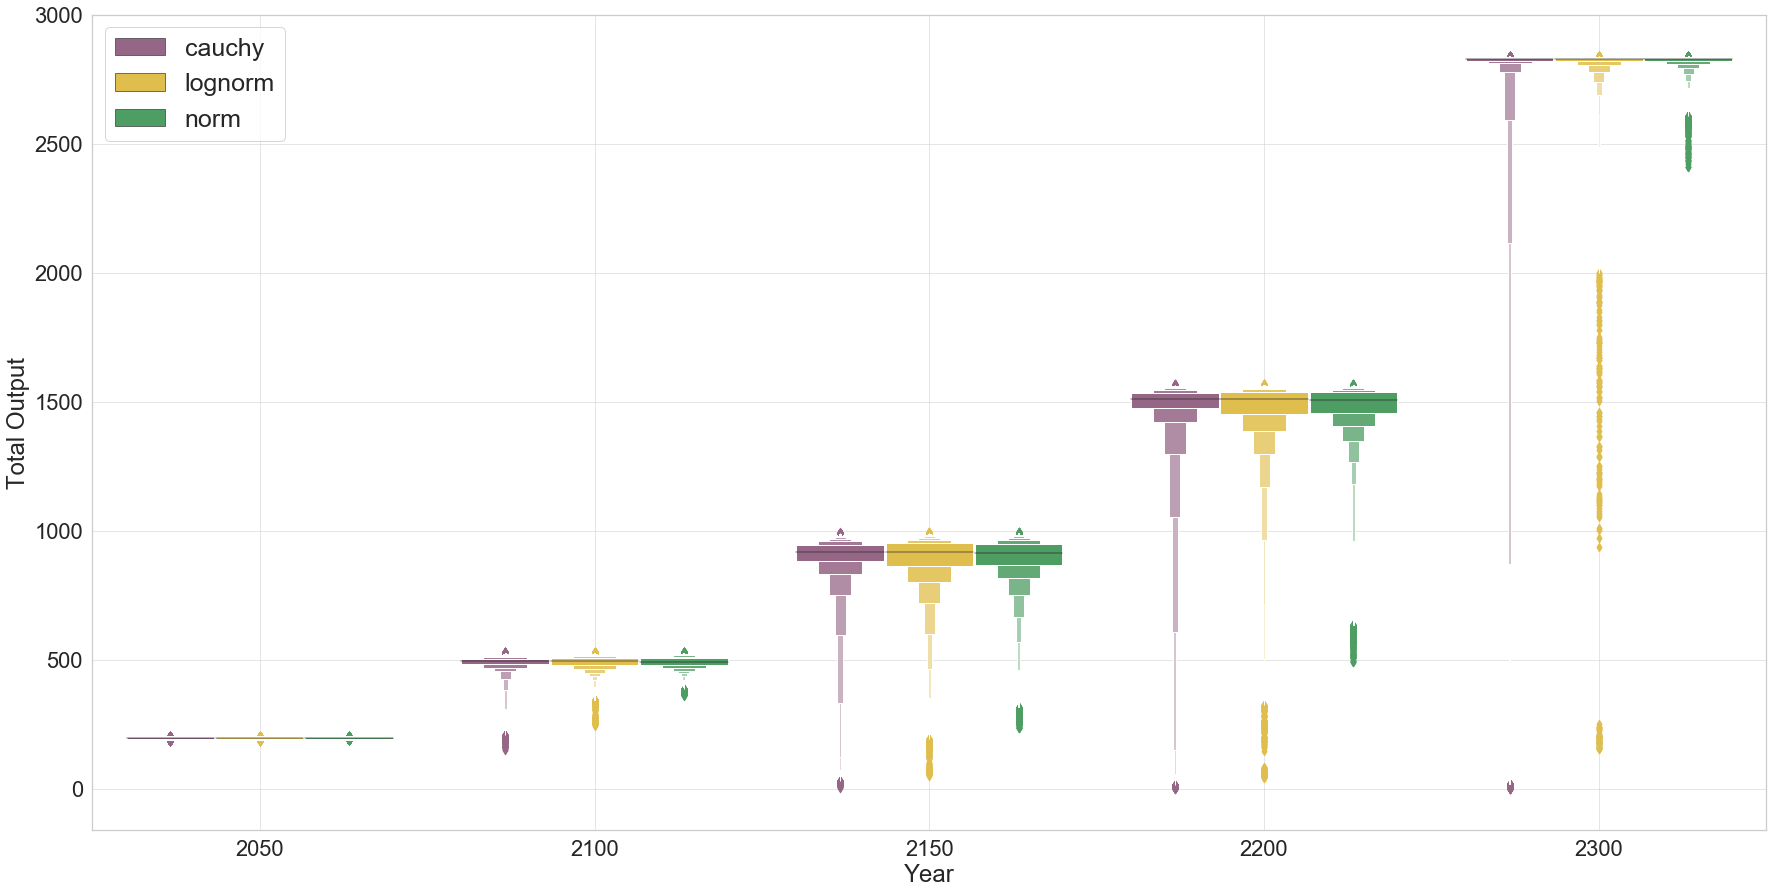

In [30]:
sns.set(style = "whitegrid", font_scale=2)
for i in range(int(len(outDF.columns.values[4:])/5)):
    box_damageDF = pd.concat([resDF.iloc[:,19+i::4],resDF['t2xco2_dist']], axis=1, join_axes = [resDF.index])
    box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","t2xco2_dist"]    
    box_damageDF = box_damageDF.melt(id_vars=['t2xco2_dist'], var_name="Year" , value_name=outDF.columns.values[i][:-5])
    box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=True)
    plt.figure(figsize=(30, 15))
    distbox = sns.boxenplot(x="Year", y=outDF.columns.values[i][:-5], data=box_damageDF, hue="t2xco2_dist", palette=clr_palette)
    distbox.legend(fontsize=25)
    #distbox.axes.set_xticklabels(labels=box_damageDF["variable"].unique(), rotation=45)
    distbox.axes.grid(alpha=0.5)
    distbox.figure.savefig('boxenplot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png')

#### Describe the statistical results of the model outcome

In [31]:
norm_desc_DF = resDF[resDF["t2xco2_dist"] == "norm"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_norm = []
for _ in norm_desc_DF.columns.values:
    colmn_norm.append(_+' Normal')
norm_desc_DF.columns = colmn_norm


lognorm_desc_DF = resDF[resDF["t2xco2_dist"] == "lognorm"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_lognorm = []
for _ in lognorm_desc_DF.columns.values:
    colmn_lognorm.append(_+' Lognormal')
lognorm_desc_DF.columns = colmn_lognorm


cauchy_desc_DF = resDF[resDF["t2xco2_dist"] == "cauchy"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_cauchy = []
for _ in cauchy_desc_DF.columns.values:
    colmn_cauchy.append(_+' Cauchy')
cauchy_desc_DF.columns = colmn_cauchy

In [32]:
dist_describeDF = pd.concat([norm_desc_DF, lognorm_desc_DF, cauchy_desc_DF], axis = 1, join_axes = [norm_desc_DF.index])

In [33]:
dist_describeDF = dist_describeDF.sort_index(axis=1)

In [34]:
dist_describeDF

Atmospheric Temperature 2050 Cauchy  \
count                        180000.000000   
mean                              1.929746   
std                               0.418041   
min                               0.274103   
1%                                0.392460   
5%                                1.106143   
10%                               1.489419   
25%                               1.798106   
50%                               1.983919   
75%                               2.138675   
90%                               2.330488   
95%                               2.508338   
99%                               2.813687   
max                               2.983667   

       Atmospheric Temperature 2050 Lognormal  \
count                           180000.000000   
mean                                 1.893237   
std                                  0.456793   
min                                  0.241125   
1%                                   0.466666   
5%                                   0.989315   
10%                                  1.268709   
25%                                  1.651324   
50%                                  1.983207   
75%                                  2.224587   
90%                                  2.390728   
95%                                  2.477189   
99%                                  2.607414   
max                                  2.829866   

       Atmospheric Temperature 2050 Normal  \
count                        180000.000000   
mean                              1.892596   
std                               0.455004   
min                               0.238191   
1%                                0.358112   
5%                                0.946809   
10%                               1.274472   
25%                               1.705756   
50%                               2.004632   
75%                               2.207369   
90%                               2.347630   
95%                               2.410444   
99%                               2.530719   
max                               2.607188   

       Atmospheric Temperature 2100 Cauchy  \
count                        180000.000000   
mean                              3.256928   
std                               0.936537   
min                               0.341266   
1%                                0.514679   
5%                                1.534403   
10%                               2.212483   
25%                               2.851746   
50%                               3.285944   
75%                               3.689770   
90%                               4.235914   
95%                               4.818695   
99%                               5.843310   
max                               6.583334   

       Atmospheric Temperature 2100 Lognormal  \
count                           180000.000000   
mean                                 3.189468   
std                                  1.002137   
min                                  0.267347   
1%                                   0.600795   
5%                                   1.366683   
10%                                  1.822312   
25%                                  2.539183   
50%                                  3.288685   
75%                                  3.923385   
90%                                  4.415076   
95%                                  4.679258   
99%                                  5.105895   
max                                  5.996206   

       Atmospheric Temperature 2100 Normal  \
count                        180000.000000   
mean                              3.182666   
std                               0.964284   
min                               0.268872   
1%                                0.459540   
5%                                1.287279   
10%                               1.824354   
25%                               2.643213   
50%                               3.340785   
75

In [35]:
splitDF = np.split(dist_describeDF, [15,30,45], axis=1)

In [37]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
sheet_name.sort()

In [38]:
with pd.ExcelWriter("statistical_description_dist_VAR.xlsx") as writer:
    for i in range(4):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])

In [39]:
# fig, ax = plt.subplots()
# resDF["Atmospheric Temperature 2100"].hist(bins=30, ax=ax)
# ax.set_xlim(5, 10)
# ax.set_ylim(0, 8000)

### Damage Functions

In [40]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF["fdamage"]))):
#             sns.distplot(resDF[resDF["fdamage"] == np.unique(resDF["fdamage"])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF["fdamage"])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

In [41]:
# fig.savefig('distplot_'+'fdamage'+'_nordhaus_opt_policy'+'_V3.png')

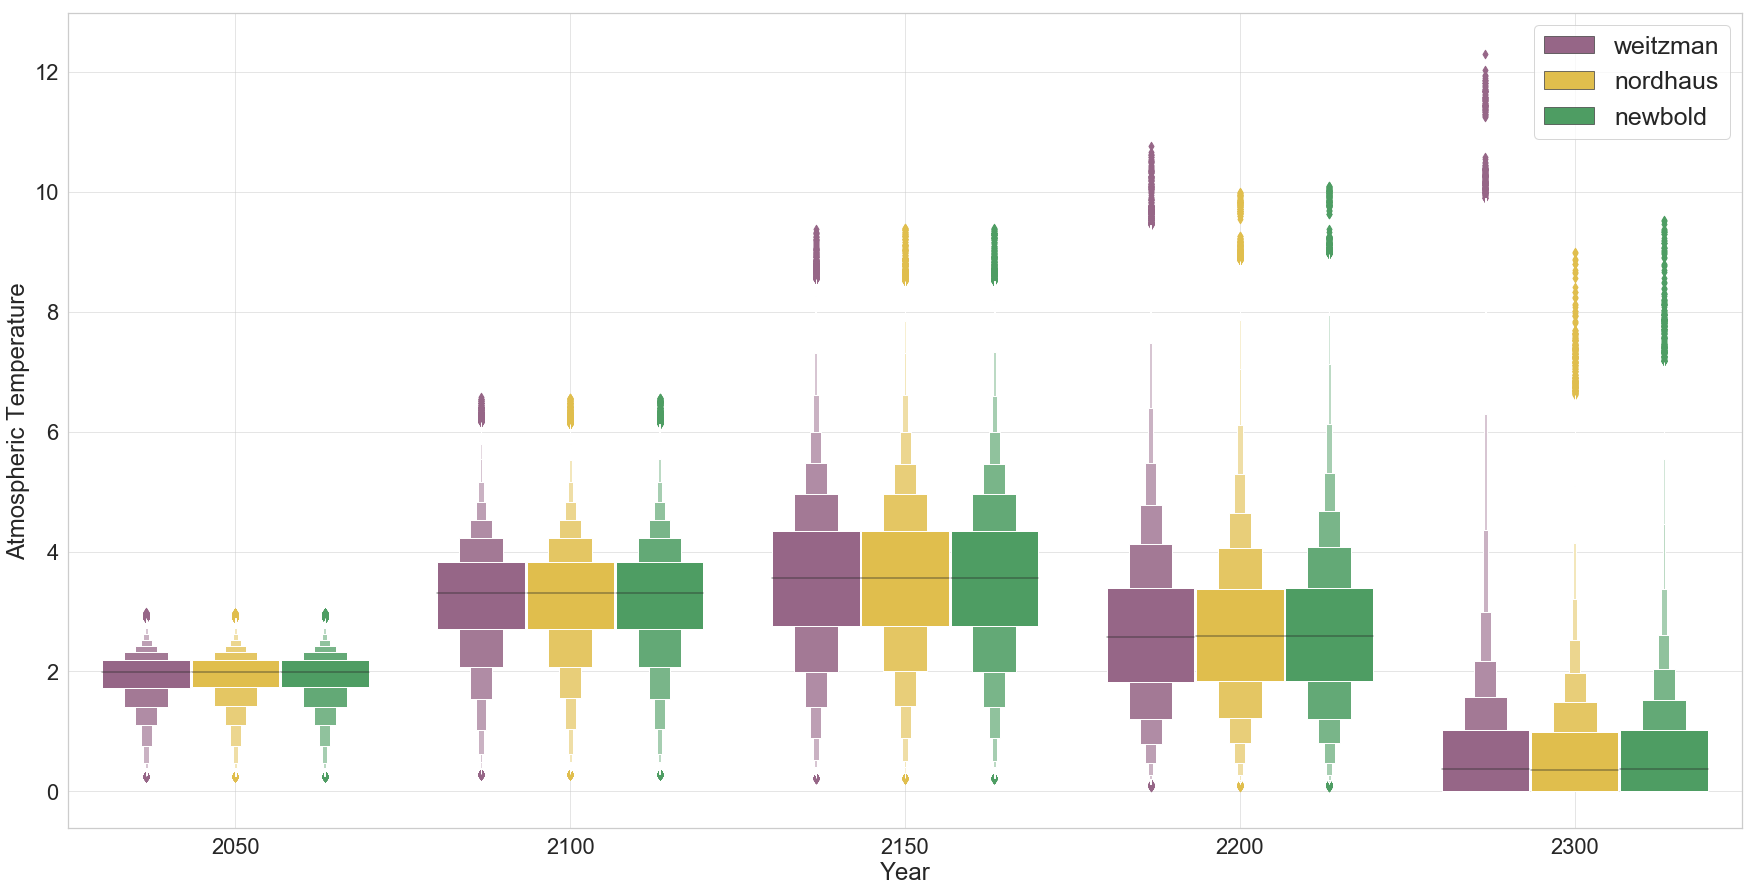

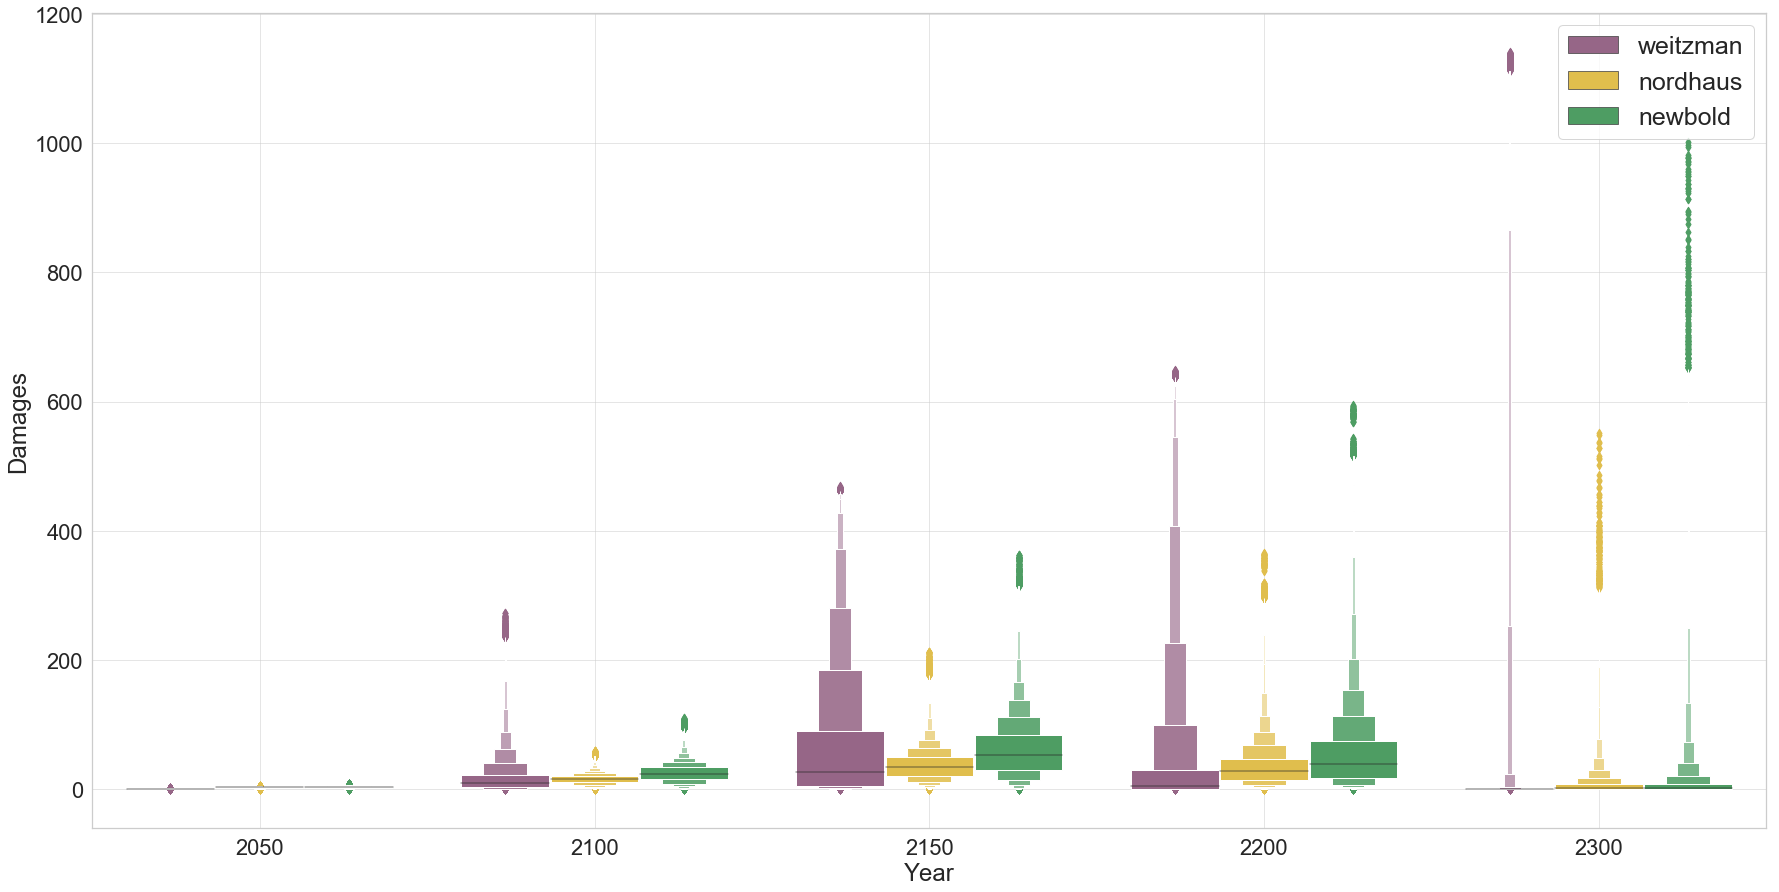

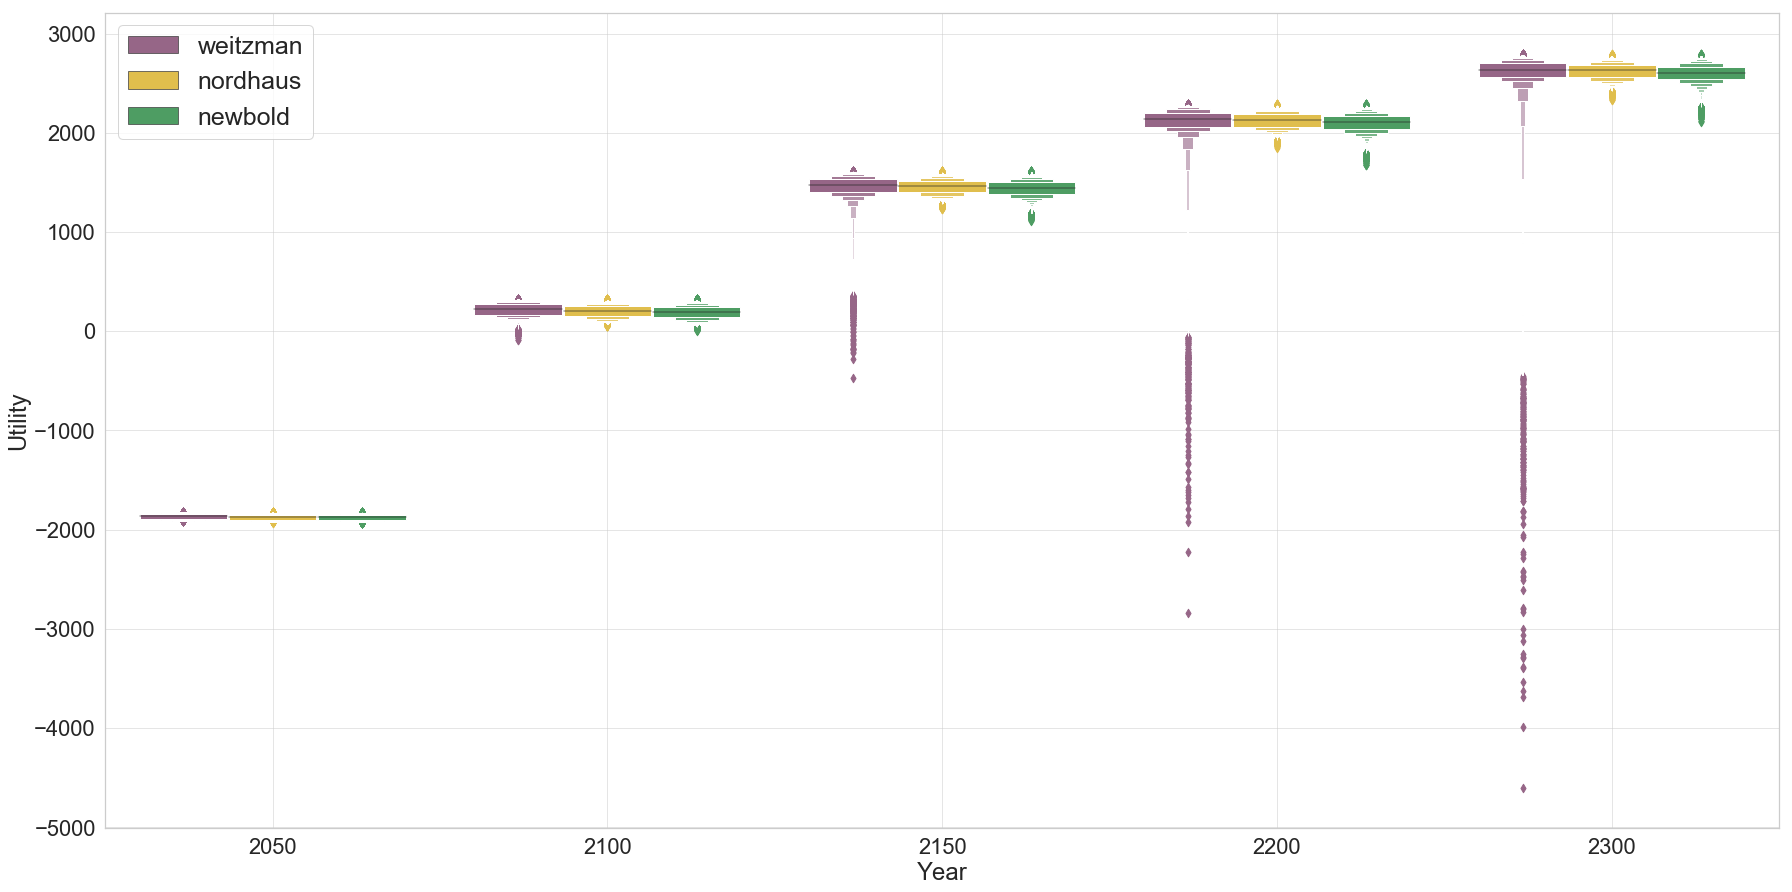

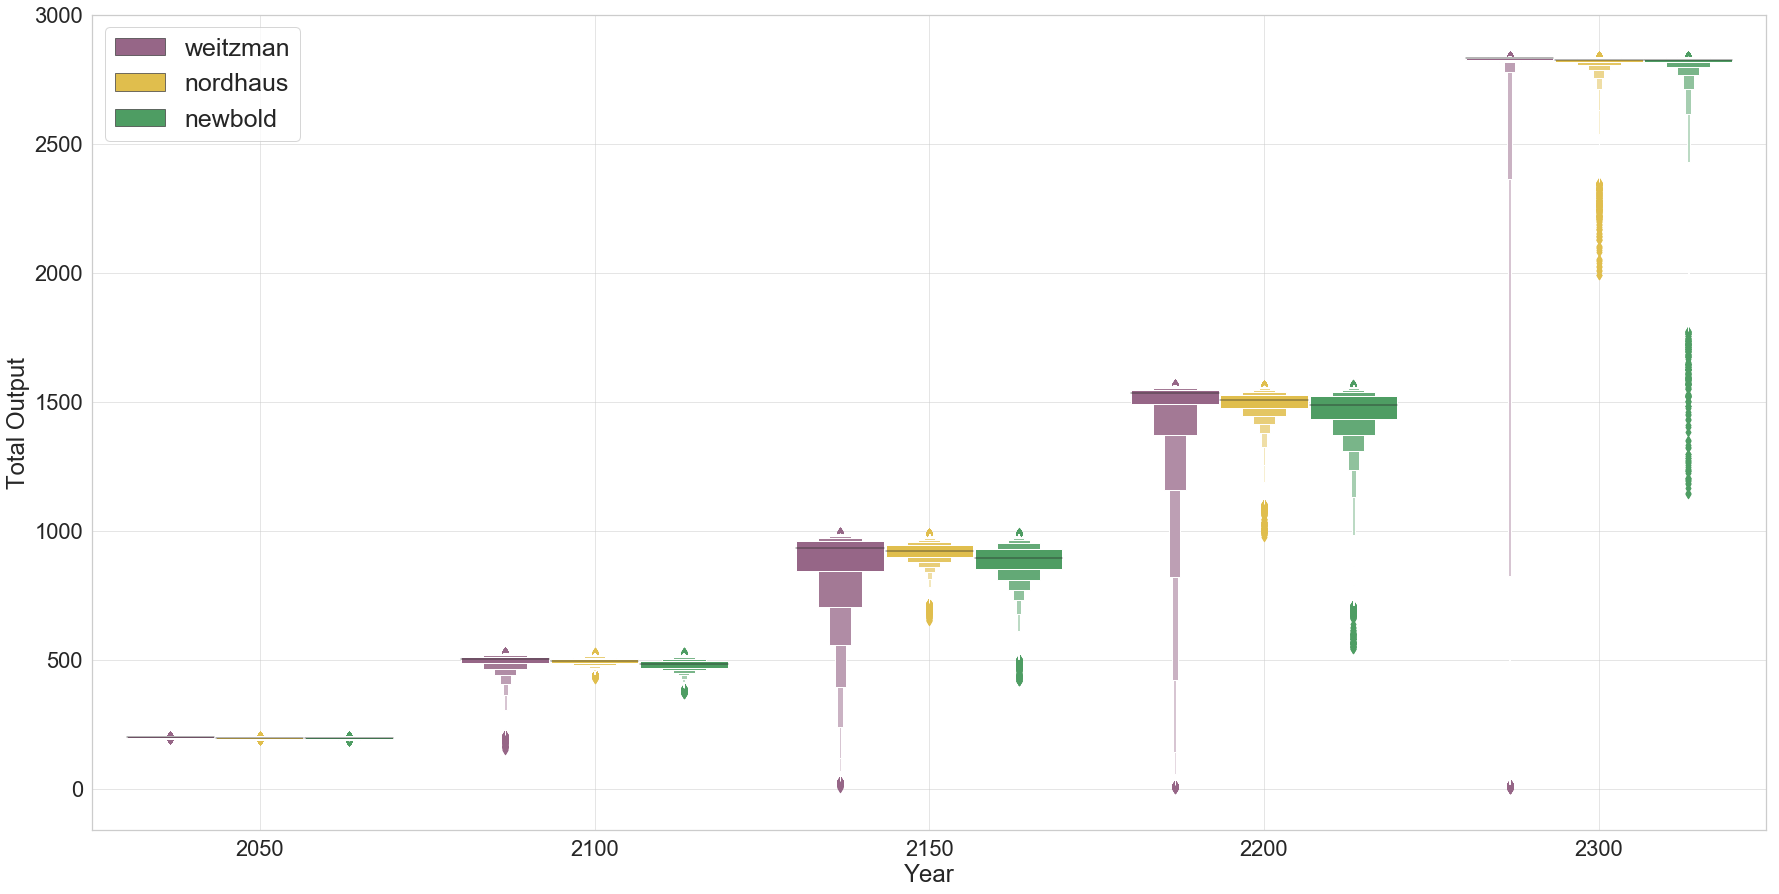

In [42]:
for i in range(int(len(outDF.columns.values[4:])/5)):
    box_damageDF = pd.concat([resDF.iloc[:,19+i::4],resDF['fdamage']], axis=1, join_axes = [resDF.index])
    box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","fdamage"]    
    box_damageDF = box_damageDF.melt(id_vars=['fdamage'], var_name="Year" , value_name=outDF.columns.values[i][:-5])
    box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=False)
    plt.figure(figsize=(30, 15))
    distbox = sns.boxenplot(x="Year", y=outDF.columns.values[i][:-5], data=box_damageDF, hue="fdamage", palette=clr_palette)
    distbox.legend(fontsize=25)
    distbox.axes.grid(alpha=0.5)
    distbox.figure.savefig('fdamageplot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png')

#### Describe the statistical results of the model outcome

In [43]:
nord_desc_DF = resDF[resDF["fdamage"] == "nordhaus"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_nord = []
for _ in nord_desc_DF.columns.values:
    colmn_nord.append(_+' Nordhaus')
nord_desc_DF.columns = colmn_nord


new_desc_DF = resDF[resDF["fdamage"] == "newbold"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_new = []
for _ in new_desc_DF.columns.values:
    colmn_new.append(_+' Newbold')
new_desc_DF.columns = colmn_new


weitz_desc_DF = resDF[resDF["fdamage"] == "weitzman"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_weitz = []
for _ in weitz_desc_DF.columns.values:
    colmn_weitz.append(_+' Weitzman')
weitz_desc_DF.columns = colmn_weitz

In [44]:
dist_fdamageDF = pd.concat([nord_desc_DF, new_desc_DF, weitz_desc_DF], axis = 1, join_axes = [norm_desc_DF.index])

In [45]:
dist_fdamageDF = dist_fdamageDF.sort_index(axis=1, ascending=True)

In [46]:
dist_fdamageDF

Atmospheric Temperature 2050 Newbold  \
count                         180000.000000   
mean                               1.905339   
std                                0.444210   
min                                0.238821   
1%                                 0.390228   
5%                                 0.991816   
10%                                1.317756   
25%                                1.732396   
50%                                1.989423   
75%                                2.192915   
90%                                2.361964   
95%                                2.458811   
99%                                2.702225   
max                                2.980520   

       Atmospheric Temperature 2050 Nordhaus  \
count                          180000.000000   
mean                                1.906269   
std                                 0.443259   
min                                 0.239045   
1%                                  0.390383   
5%                                  0.995290   
10%                                 1.324466   
25%                                 1.734594   
50%                                 1.990376   
75%                                 2.192185   
90%                                 2.361872   
95%                                 2.457620   
99%                                 2.699732   
max                                 2.980354   

       Atmospheric Temperature 2050 Weitzman  \
count                          180000.000000   
mean                                1.903971   
std                                 0.444463   
min                                 0.238191   
1%                                  0.390756   
5%                                  0.990030   
10%                                 1.317887   
25%                                 1.730876   
50%                                 1.988416   
75%                                 2.190779   
90%                                 2.362399   
95%                                 2.458220   
99%                                 2.702628   
max                                 2.983667   

       Atmospheric Temperature 2100 Newbold  \
count                         180000.000000   
mean                               3.208250   
std                                0.968216   
min                                0.268824   
1%                                 0.507820   
5%                                 1.371795   
10%                                1.907442   
25%                                2.702449   
50%                                3.300094   
75%                                3.832514   
90%                                4.318101   
95%                                4.621339   
99%                                5.433229   
max                                6.561633   

       Atmospheric Temperature 2100 Nordhaus  \
count                          180000.000000   
mean                                3.211442   
std                                 0.966924   
min                                 0.267547   
1%                                  0.508129   
5%                                  1.378647   
10%                                 1.914472   
25%                                 2.706596   
50%                                 3.303382   
75%                                 3.831741   
90%                                 4.321681   
95%                                 4.618796   
99%                                 5.427095   
max                                 6.556691   

       Atmospheric Temperature 2100 Weitzman  \
count                          180000.000000   
mean                                3.209371   
std                                 0.970673   
min                                 0.267347   
1%                                  0.509292   
5%                                  1.372208   
10%                                 1.907603   
25%                                 2.700721   


In [47]:
splitDF = np.split(dist_fdamageDF, [15,30,45], axis=1)

In [48]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
sheet_name.sort()

In [49]:
with pd.ExcelWriter("statistical_description_fdamage_VAR.xlsx") as writer:
    for i in range(4):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])

### Damage Functions and Distributions

In [50]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF[resDF.columns[-1]]))):
#             sns.distplot(resDF[resDF[resDF.columns[-1]] == np.unique(resDF[resDF.columns[-1]])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF[resDF.columns[-1]])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

In [51]:
# fig.savefig('distplot_'+'fdamage_dist'+'_nordhaus_opt_policy'+'_V3.png')

In [52]:
sns.set(style = "whitegrid", palette=sns.set_palette("tab10"), font_scale=2)

In [53]:
outDF = pd.DataFrame(outcomes)
expDF = experiments

resDF = pd.concat([expDF,outDF], axis=1, join_axes=[expDF.index])

resDF['t2xco2_dist'] = resDF['t2xco2_dist'].apply(lambda x: ' and norm' if x==0 else (' and lognorm' if x==1 else ' and cauchy'))
resDF['fdamage'] = resDF['fdamage'].apply(lambda x: 'nordhaus' if x==0 else ('newbold' if x==1 else 'weitzman'))
resDF['fdamage_and_t2xco2_dist'] = resDF['fdamage'] + resDF['t2xco2_dist']

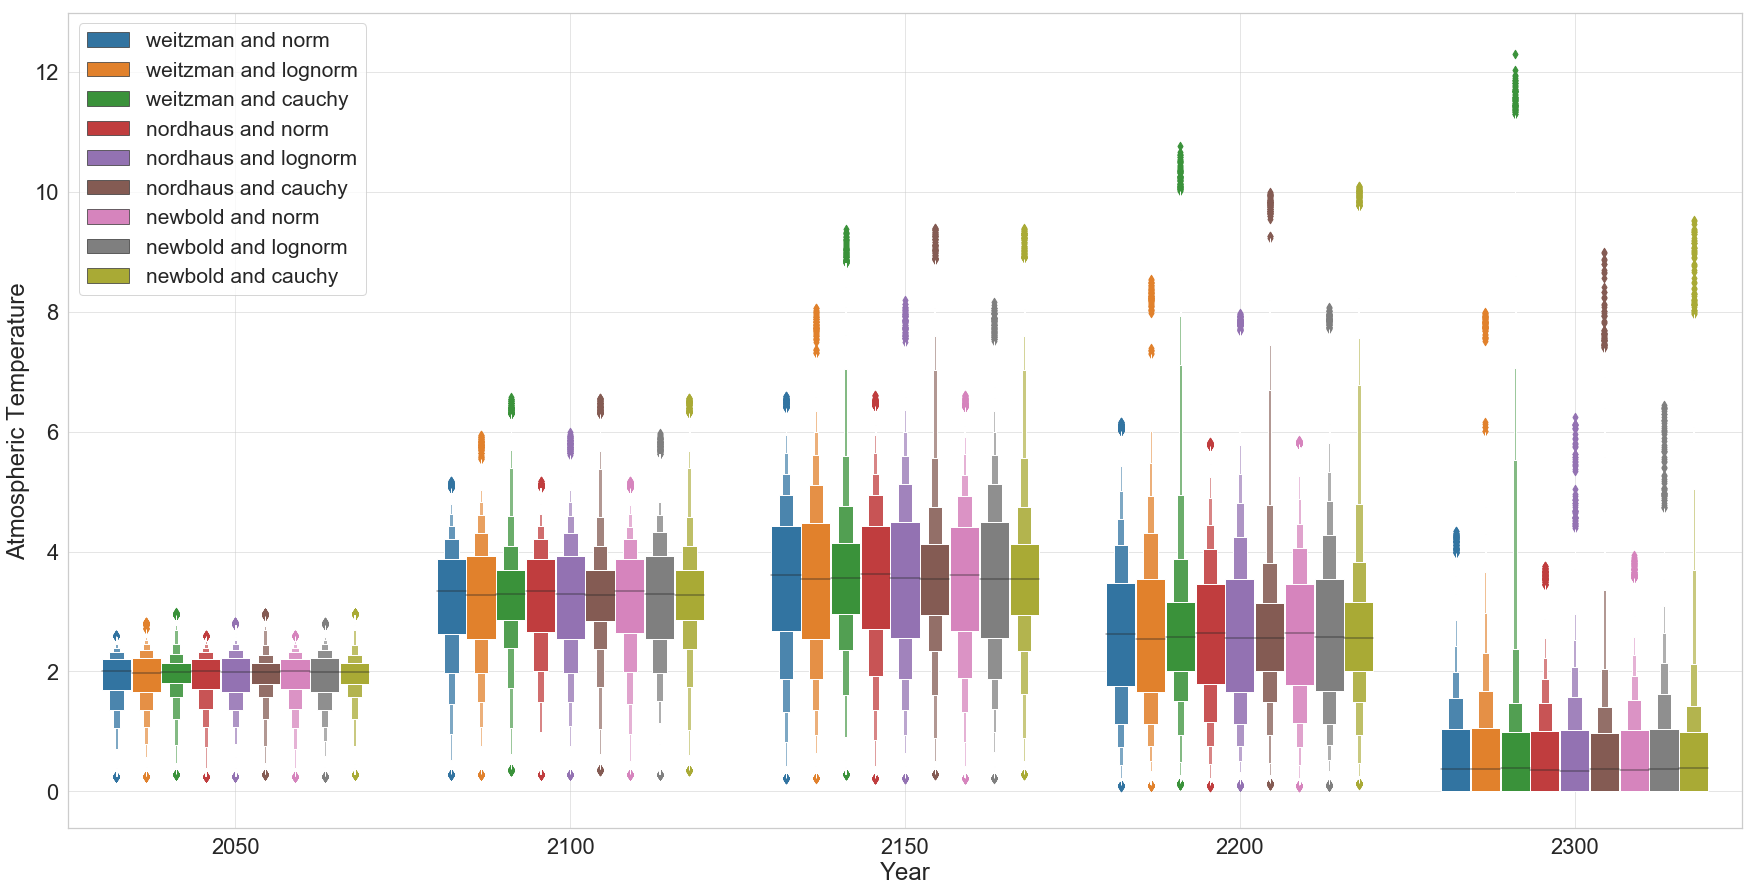

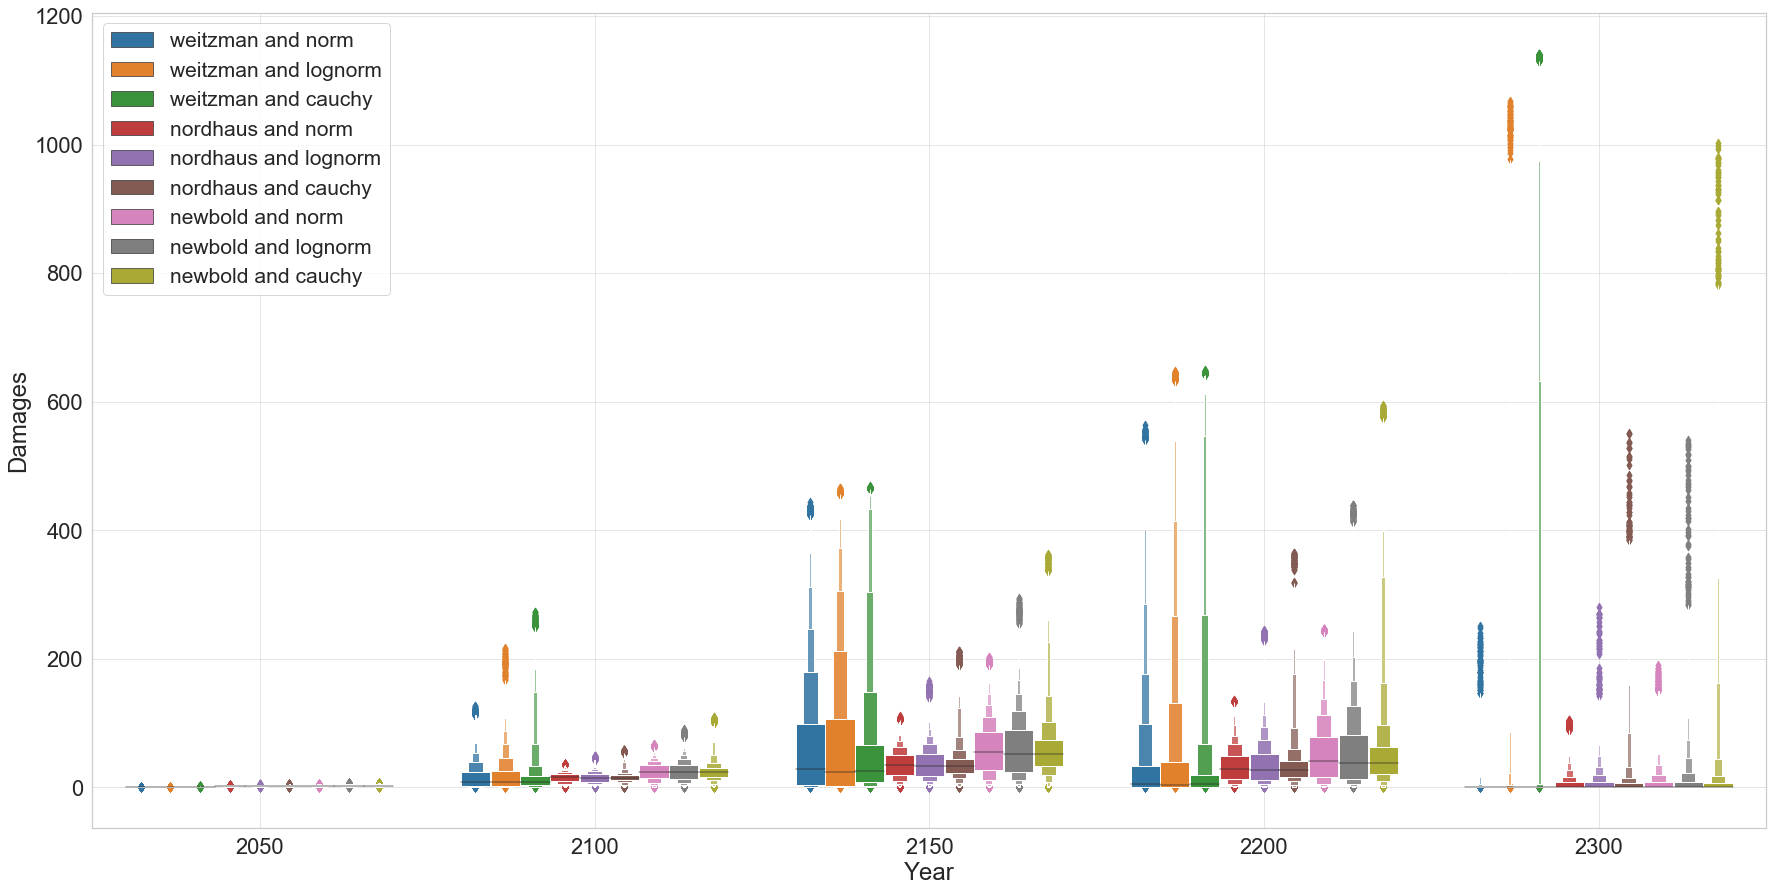

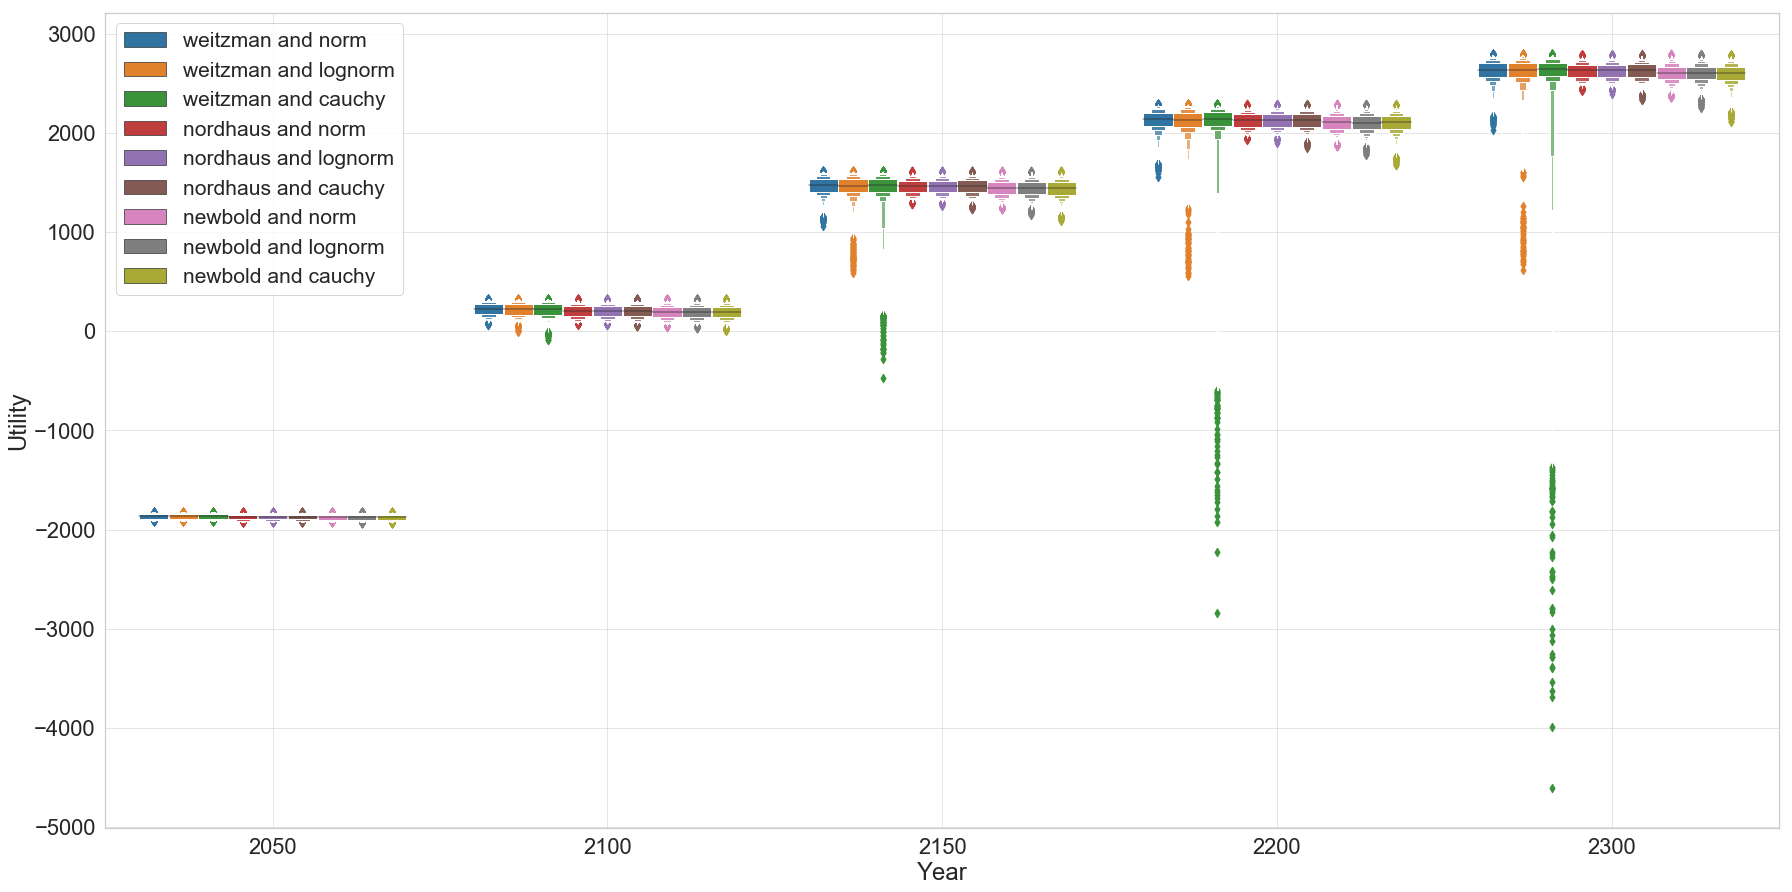

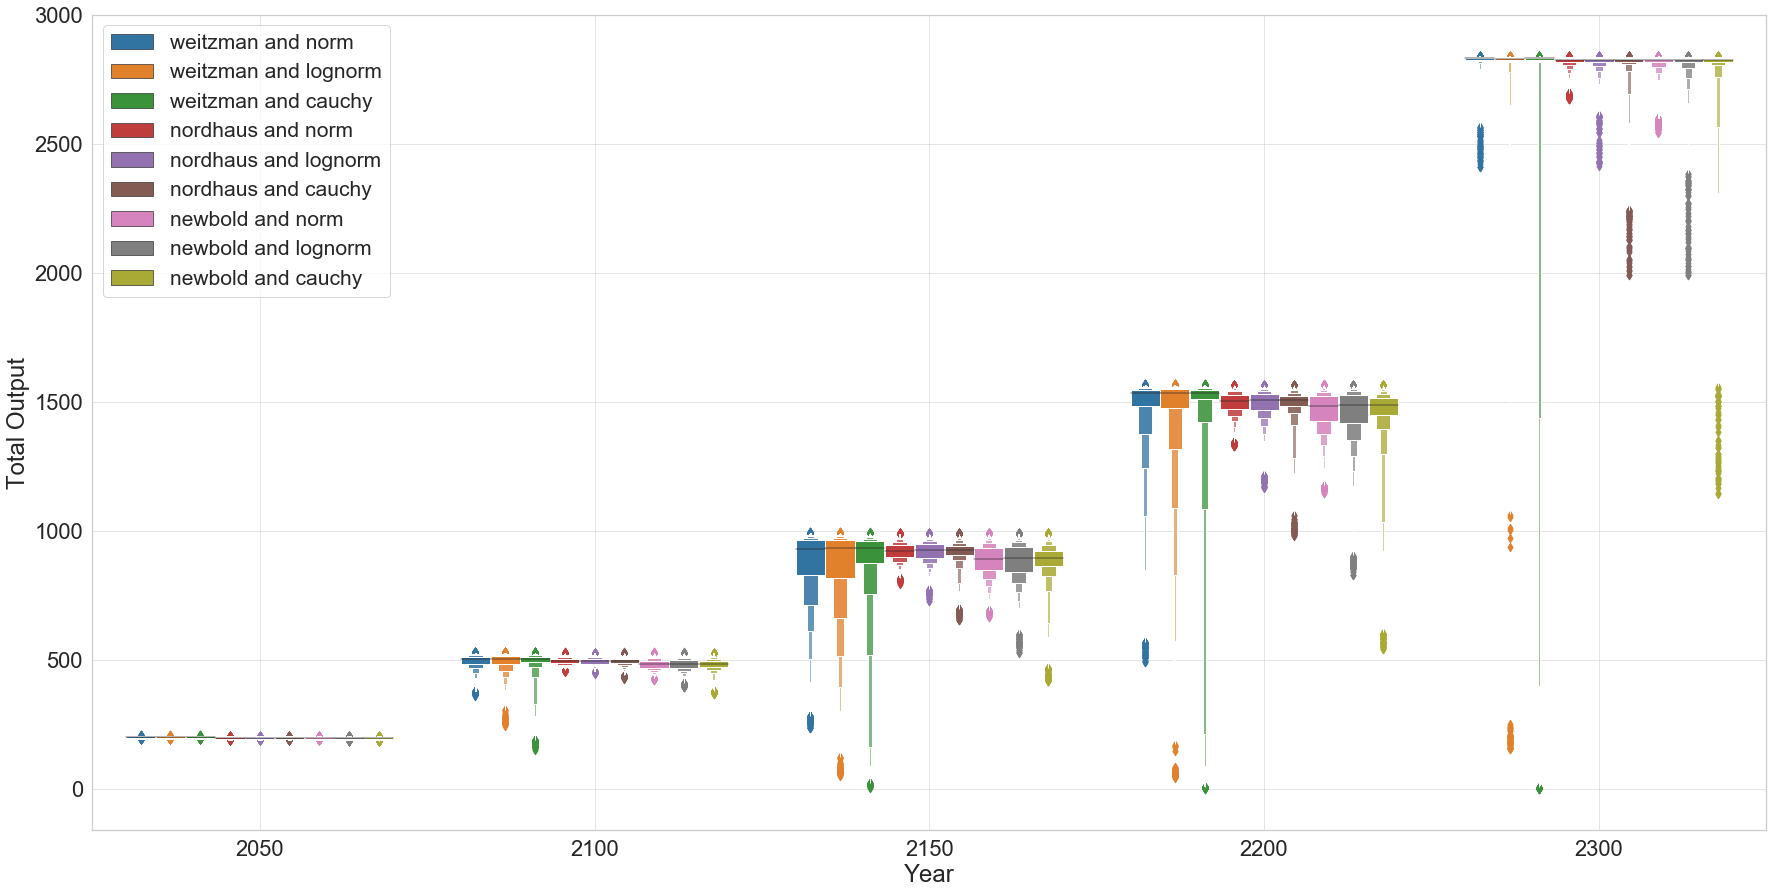

In [54]:
for i in range(int(len(outDF.columns.values[4:])/5)):
    box_damageDF = pd.concat([resDF.iloc[:,19+i:-1:4],resDF['fdamage_and_t2xco2_dist']], axis=1, join_axes=[resDF.index])
    box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","fdamage_and_t2xco2_dist"]    
    box_damageDF = box_damageDF.melt(id_vars=["fdamage_and_t2xco2_dist"], var_name="Year" , value_name=outDF.columns.values[i][:-5])
    box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=False)
    plt.figure(figsize=(30, 15))
    distbox = sns.boxenplot(x="Year", y=outDF.columns.values[i][:-5], data=box_damageDF, hue="fdamage_and_t2xco2_dist",)
    distbox.legend(fontsize=21)
    distbox.axes.grid(alpha=0.5)
    distbox.figure.savefig('fdamage_dist_boxen_plot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png')

In [55]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF[resDF.columns[-1]]))):
#             sns.distplot(resDF[resDF[resDF.columns[-1]] == np.unique(resDF[resDF.columns[-1]])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF[resDF.columns[-1]])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

### Describe the statistical results of the model outcome

In [56]:
# for i,j in enumerate(np.unique(resDF[resDF.columns[-1]])):
#     print(i,j)


In [57]:
# res_descDF = resDF.iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

In [58]:
# np.unique(resDF[resDF.columns[-1]])

In [59]:
# weitz_desc_DF = resDF[resDF["fdamage"] == "weitzman"].iloc[:,19:].describe(percentiles = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975])

# colmn_weitz = []
# for _ in weitz_desc_DF.columns.values:
#     colmn_weitz.append(_+' Weitzman')

# weitz_desc_DF.columns = colmn_weitz

In [60]:
# res_descDF

In [61]:
res_descDF = pd.DataFrame([])
for j in (np.unique(resDF[resDF.columns[-1]])):
    descDF = resDF[resDF['fdamage_and_t2xco2_dist'] == j].iloc[:,19:-1].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]) 
    column_res = []
    for _ in descDF.columns.values:
        column_res.append(_ +"_"+ j)
    descDF.columns = column_res
    res_descDF = res_descDF.append(descDF.T)

res_descDF = res_descDF.T.sort_index(axis=1)

In [62]:
res_descDF

Atmospheric Temperature 2050_newbold and cauchy  \
count                                     59864.000000   
mean                                          1.929079   
std                                           0.418742   
min                                           0.274595   
1%                                            0.392184   
5%                                            1.104977   
10%                                           1.486861   
25%                                           1.797444   
50%                                           1.983093   
75%                                           2.138404   
90%                                           2.327963   
95%                                           2.506570   
99%                                           2.813636   
max                                           2.980520   

       Atmospheric Temperature 2050_newbold and lognorm  \
count                                      60187.000000   
mean                                           1.894939   
std                                            0.455945   
min                                            0.241445   
1%                                             0.476039   
5%                                             0.993122   
10%                                            1.266806   
25%                                            1.652813   
50%                                            1.984700   
75%                                            2.226608   
90%                                            2.392867   
95%                                            2.478610   
99%                                            2.606925   
max                                            2.828546   

       Atmospheric Temperature 2050_newbold and norm  \
count                                   59949.000000   
mean                                        1.892074   
std                                         0.455876   
min                                         0.238821   
1%                                          0.355207   
5%                                          0.912659   
10%                                         1.273266   
25%                                         1.704772   
50%                                         2.004213   
75%                                         2.207510   
90%                                         2.346591   
95%                                         2.410302   
99%                                         2.528814   
max                                         2.607188   

       Atmospheric Temperature 2050_nordhaus and cauchy  \
count                                      60062.000000   
mean                                           1.928452   
std                                            0.418166   
min                                            0.274266   
1%                                             0.391994   
5%                                             1.103853   
10%                                            1.488366   
25%                                            1.797300   
50%                                            1.982491   
75%                                            2.137610   
90%                                            2.329645   
95%                                            2.505982   
99%                                            2.812798   
max                                            2.980354   

       Atmospheric Temperature 2050_nordhaus and lognorm  \
count                                       59764.000000   
mean                                            1.893715   
std                                             0.457900   
min                                             0.241125   
1%                                              0.414499   
5%                                              0.986604   
10%                                             1.269740   
25%                                        

In [63]:
splitDF = np.split(res_descDF, [45,90,135], axis=1)

In [64]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
sheet_name.sort()

In [65]:
with pd.ExcelWriter("statistical_description_dist_fdamage_VAR.xlsx") as writer:
    for i in range(4):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])